# DHCR24 Mouse Hepatocyte

In [2]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2


In [3]:
### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import sklearn
from sklearn import preprocessing
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from matplotlib_venn import venn3, venn2
import pickle

%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set_context('notebook')

## Preprocessing

In [4]:
# file directories
workingDirectory = '/home/jenhan/analysis/dhcr24_mouseHepatocyte_analysis/'
binDirectory = '/home/jenhan/bin/'
genomePath = '/bioinformatics/homer/data/genomes/mm10'
genomes = ['hg19','mm10', 'hg38']
peakDirectory = workingDirectory + 'peaks/'
scratchDirectory = workingDirectory + '/scratch/'
logFilePath = workingDirectory + '/log_files/'
tagDirPath = workingDirectory + '/tag_directories/'
inputDirectory = workingDirectory + '/input/'
idrDirectory = workingDirectory + '/idr/'

os.chdir(workingDirectory)

# map ugly file names to prettier looking file names
# if not os.path.isfile("nameMapping.tsv"):
nameMappingFile = open("nameMapping.tsv", "w")
for f in os.listdir(logFilePath):
    rootName = f
    for gen in genomes:
        rootName = rootName.replace('.' + gen + '.star.log','').replace('.' +gen + '.bowtie2.log','')
    nameMappingFile.write(rootName + '\t' + rootName + '\n')
nameMappingFile.close()

# read in and parse name mapping file and create a DataFrame representation
with open("nameMapping.tsv") as f:
    data = f.readlines()
strains = []
treatments = []
owners = []
dates = []
originalNames = []
cleanedNames = []
for line in data:
    tokens = line.strip().split("\t")
    originalName = tokens[0]
    metaDataTokens = tokens[1].split('_')
    
    originalNames.append(originalName)
    cleanedNames.append(tokens[1])
    # grab metadata from string tokens
    strain = metaDataTokens[0].strip()
    treatment = metaDataTokens[2].strip()
    owner = metaDataTokens[3].strip()
    date = metaDataTokens[4].strip()
    
    # append to overall lists
    strains.append(strain)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  treatments, 
                                  owners, 
                                  originalNames, 
                                  cleanedNames]).transpose()
metadata_frame.columns = ['strain', 
                         'treatment', 
                         'owner', 
                         'originalName', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = '-'.join([x for x in t.split('-')][:-1])
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

# create dictionary for convenience
originalName_cleanedName_dict = dict(zip(metadata_frame["originalName"], metadata_frame["sampleName"])) # {originalName:newName}
cleanedName_originalName_dict = dict(zip(metadata_frame["sampleName"], metadata_frame["originalName"])) # {newName:originalName}

### read in log files ###

# create data frame summarizing mapping quality logs
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_originalNames =[]
# from tagInfo.txt
_fragmentLengthEstimate =[]
_peakSizeEstimate = []
_tagsPerBP = []
_averageTagsPerPosition = []
_averageTagLength = []
_averageFragmentGCcontent = []

for logFile in os.listdir(logFilePath):
    with open(logFilePath + '/' + logFile) as f:
        data = f.readlines()
    rootName = logFile
    for gen in genomes:
        rootName = rootName.replace('.' + gen + '.star.log','').replace('.' +gen + '.bowtie2.log','')
    totalReads = int(data[5].split()[5])
    uniquelyMappedReads = int(data[8].split()[5])
    multiMappedReads = int(data[23].split()[8])
    unmappedReads = totalReads - uniquelyMappedReads - multiMappedReads
#     pbc = float(data[-1].split()[-1])

    _originalNames.append(rootName)
    _totalReads.append(totalReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)
for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _fragmentLengthEstimate.append(float(data[2].strip().split('=')[1]))
        _peakSizeEstimate.append(float(data[3].strip().split('=')[1]))
        _tagsPerBP.append(float(data[4].strip().split('=')[1]))
        _averageTagsPerPosition.append(float(data[5].strip().split('=')[1]))
        _averageTagLength.append(float(data[6].strip().split('=')[1]))
        _averageFragmentGCcontent.append(float(data[8].strip().split('=')[1]))
mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads,
                                   _fragmentLengthEstimate,
                                   _peakSizeEstimate,
                                   _tagsPerBP,
                                   _averageTagsPerPosition,
                                   _averageTagLength,
                                   _averageFragmentGCcontent,
                                  ]).transpose()
mappingStats_frame.columns = ['originalName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads',
                              'fragmentLengthEstimate',
                              'peakSizeEstimate',
                              'tagsPerBP',
                              'averageTagsPerPosition',
                              'averageTagLength',
                              'averageFragmentGCcontent']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']


summary_frame = metadata_frame.merge(mappingStats_frame, on='originalName')


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['simpleTreatment'].values)])
summary_frame = summary_frame.sort()
summary_frame.to_csv('qc_metrics.tsv', sep='\t', index=False)

### throw out other treatments ###
summary_frame = summary_frame[summary_frame['simpleTreatment'].isin(['Vehicle', 'Des','DMHCA', 'Mepip', 'GW', 'T09'])]

## Mapping Quality Control

### Plot Distributions of Mapping Statistics

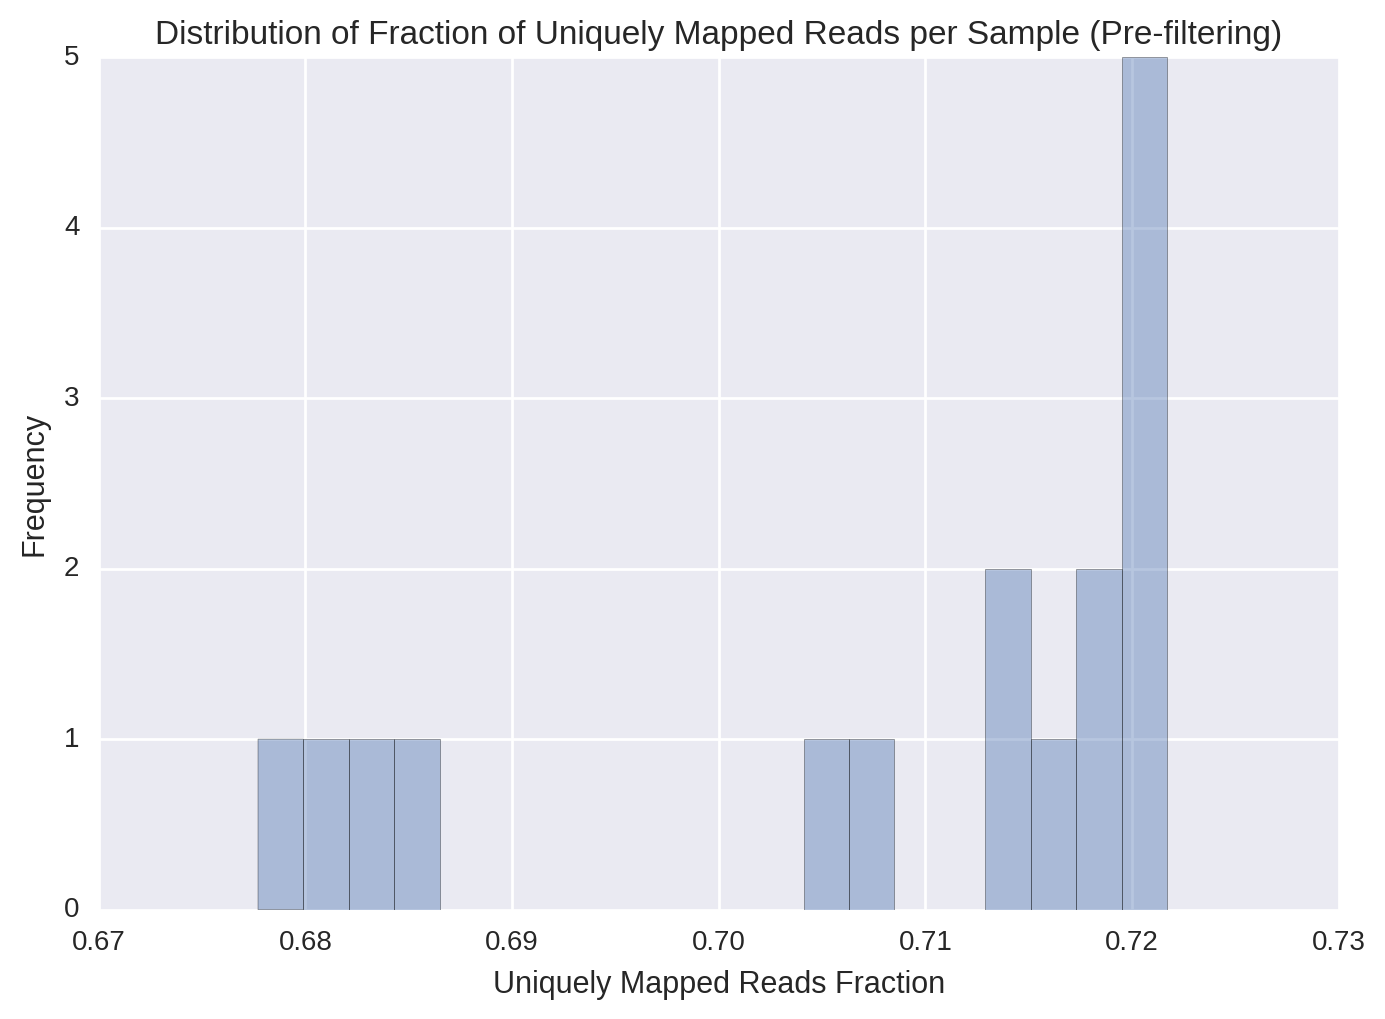

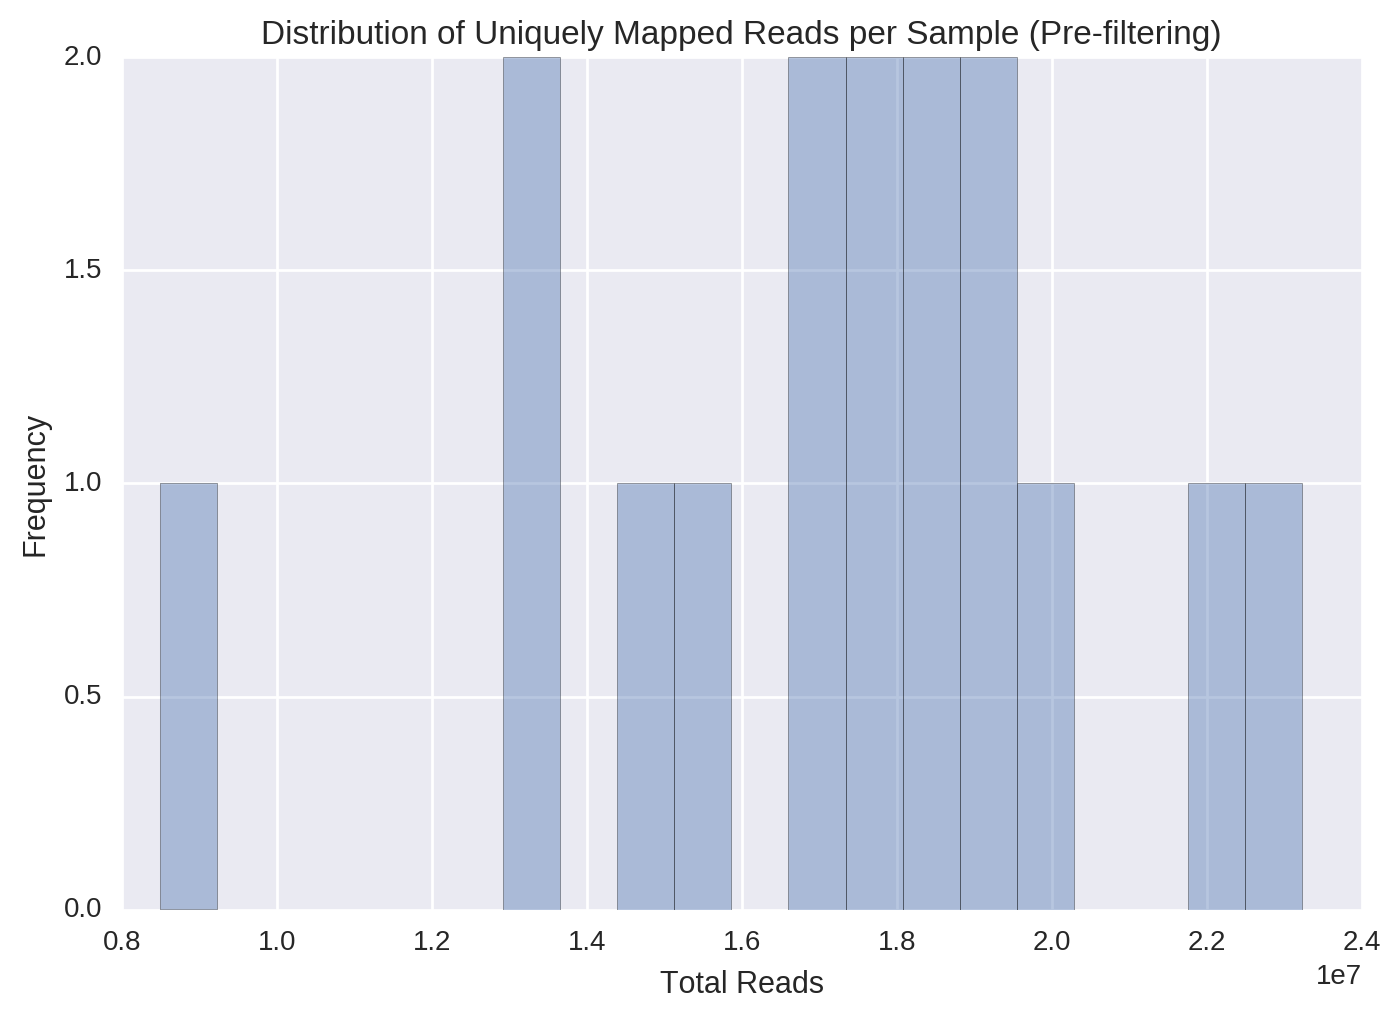

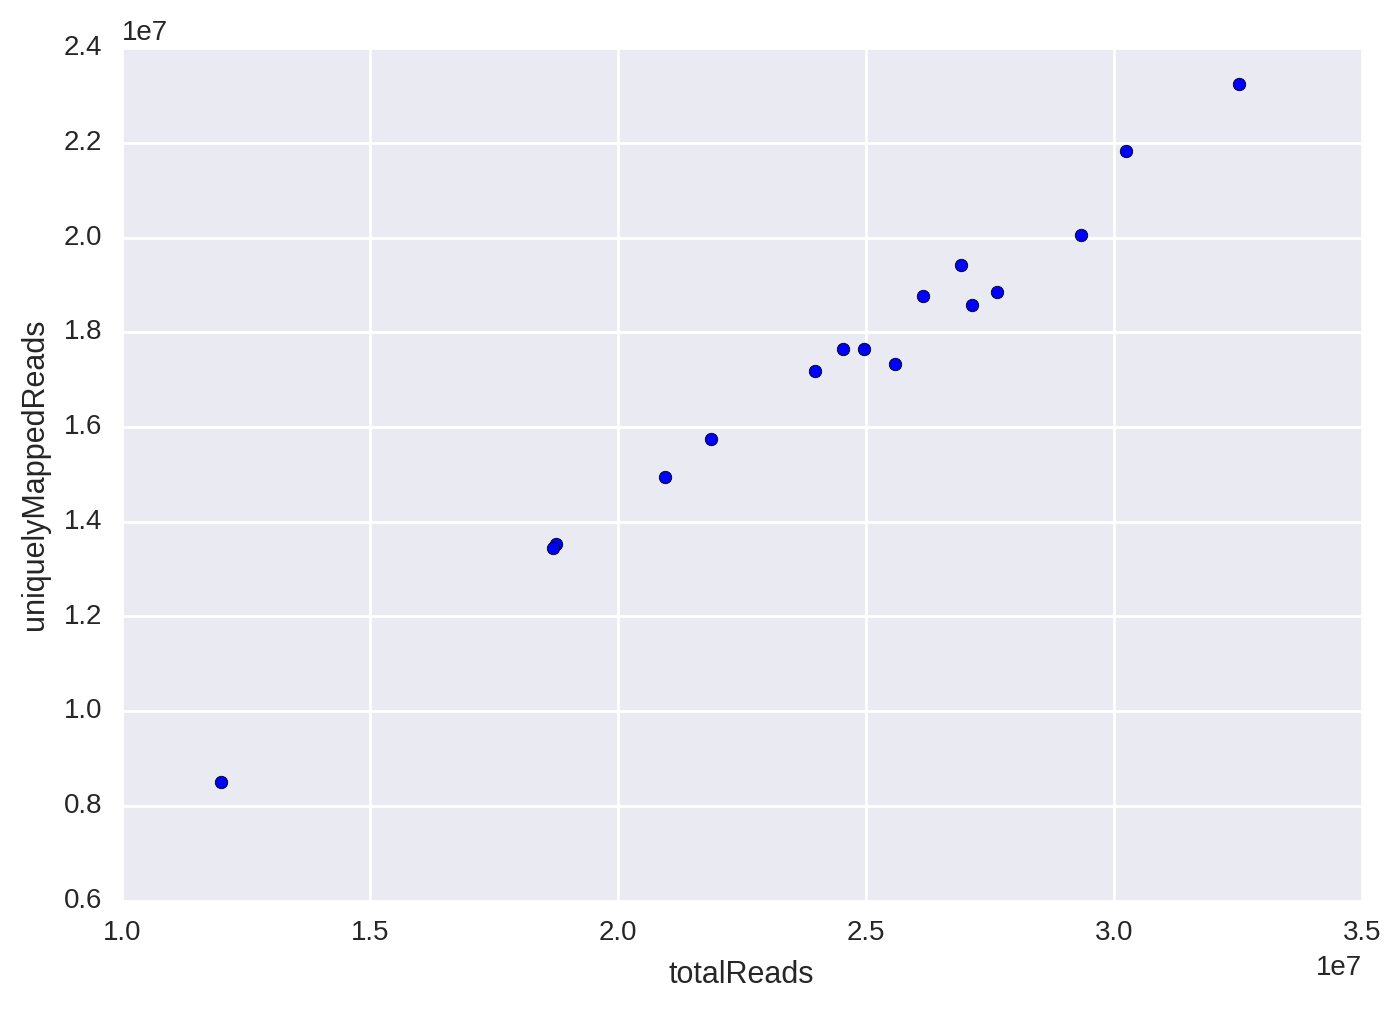

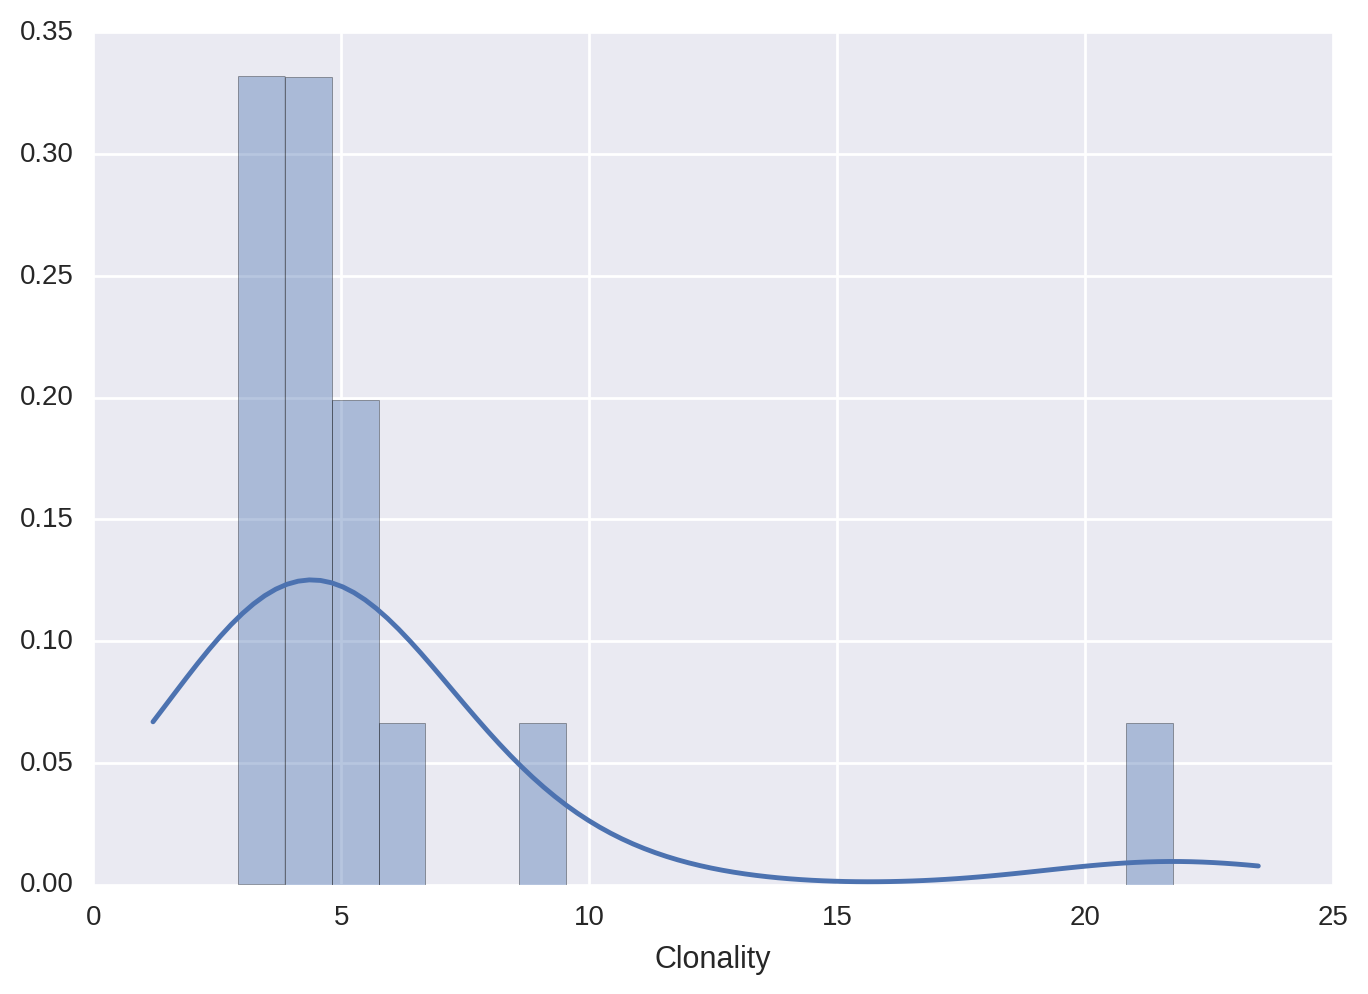

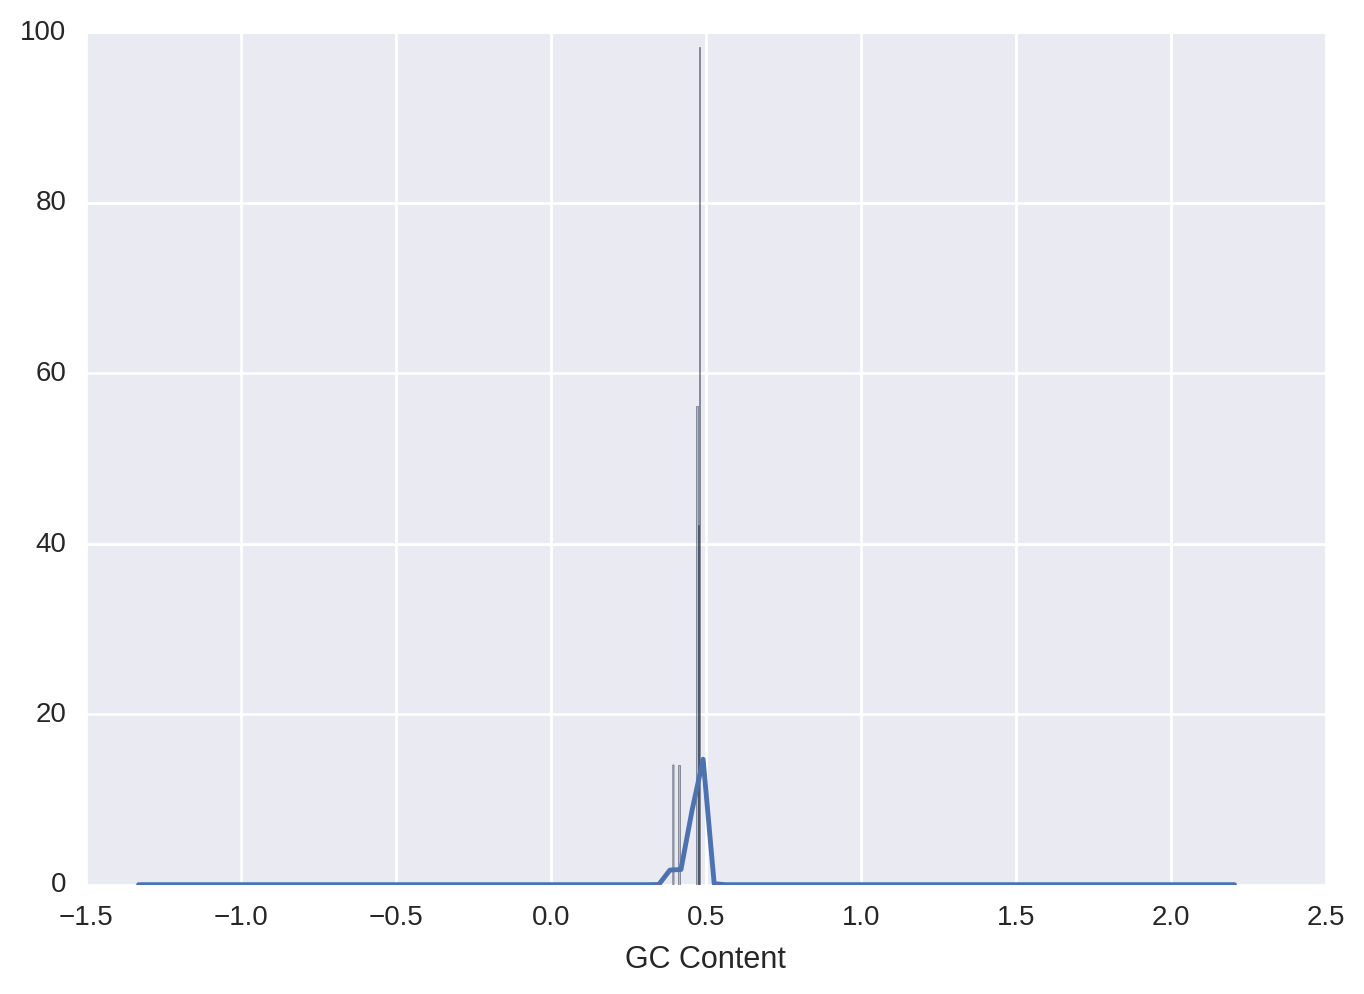

In [5]:
# plot distribution of uniquely mapped reads
sns.distplot(summary_frame['uniquelyMappedFraction'], bins=20, kde=False)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(summary_frame['uniquelyMappedReads'], bins=20, kde=False)
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Total Reads')
plt.ylabel('Frequency')
plt.show()

plt.scatter(summary_frame['totalReads'], y=summary_frame['uniquelyMappedReads'])
plt.xlabel('totalReads')
plt.ylabel('uniquelyMappedReads')
plt.show()

sns.distplot(summary_frame['averageTagsPerPosition'], bins=20)
plt.xlabel('Clonality')
plt.show()

sns.distplot(summary_frame['averageFragmentGCcontent'], bins=20)
plt.xlabel('GC Content')
plt.show()


### Filter Samples According to Mapping Quality

In [6]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.00
uniquelyMappedReadThreshold = 5000000
pbcThreshold=0.0
gcThreshold=0.12
clonalityThreshold = 10.0
# spotThreshold = 0.005

filtered_summary_frame = summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

filtered_summary_frame = filtered_summary_frame[np.abs(filtered_summary_frame['averageFragmentGCcontent'] - 0.5) <=gcThreshold]

filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['averageTagsPerPosition'] <= clonalityThreshold]


# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
simpleTreatmentCombos = filtered_summary_frame["strain"].values + '_' +filtered_summary_frame["simpleTreatment"].values
for simpleNameRoot in simpleTreatmentCombos:
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot]))
    simplifiedNames.append(simplifiedName)

filtered_summary_frame["simplifiedName"] = simplifiedNames
sampleName_simpleName_dict = dict(zip(filtered_summary_frame["sampleName"], filtered_summary_frame["simplifiedName"])) # {newName:simplifiedName}
simpleName_sampleName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["sampleName"])) # {simplifiedName:newName}

originalName_simpleName_dict = dict(zip(filtered_summary_frame["originalName"], filtered_summary_frame["simplifiedName"]))
simpleName_originalName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["originalName"])) 

filtered_summary_frame.to_csv('filtered_qc_metrics.tsv', sep='\t', index=False)

# remove specific samples
filtered_summary_frame = filtered_summary_frame[~filtered_summary_frame['originalName'].isin([
'C57Bl6-Hepatocyte_RNA_Desmosterol-1_EDM_14-11-19',
'C57Bl6-Hepatocyte_RNA_DMHCA-1_EDM_14-11-19'     
        ])]


Number of Samples: 16
Number of discarded samples: 1
Number of Samples remaining after filtering: 15


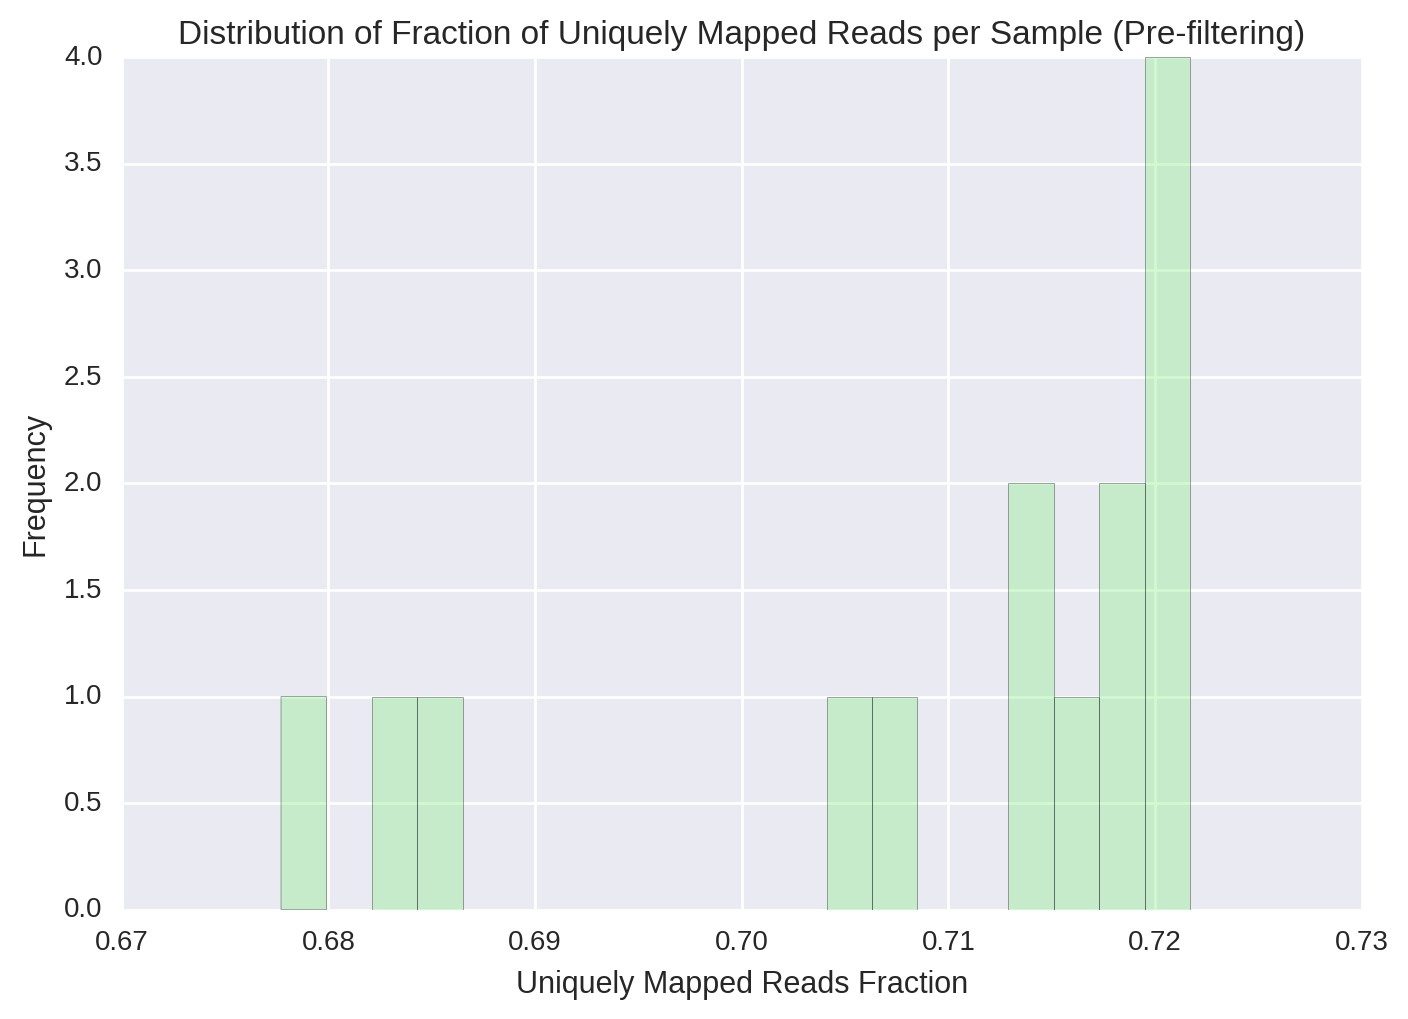

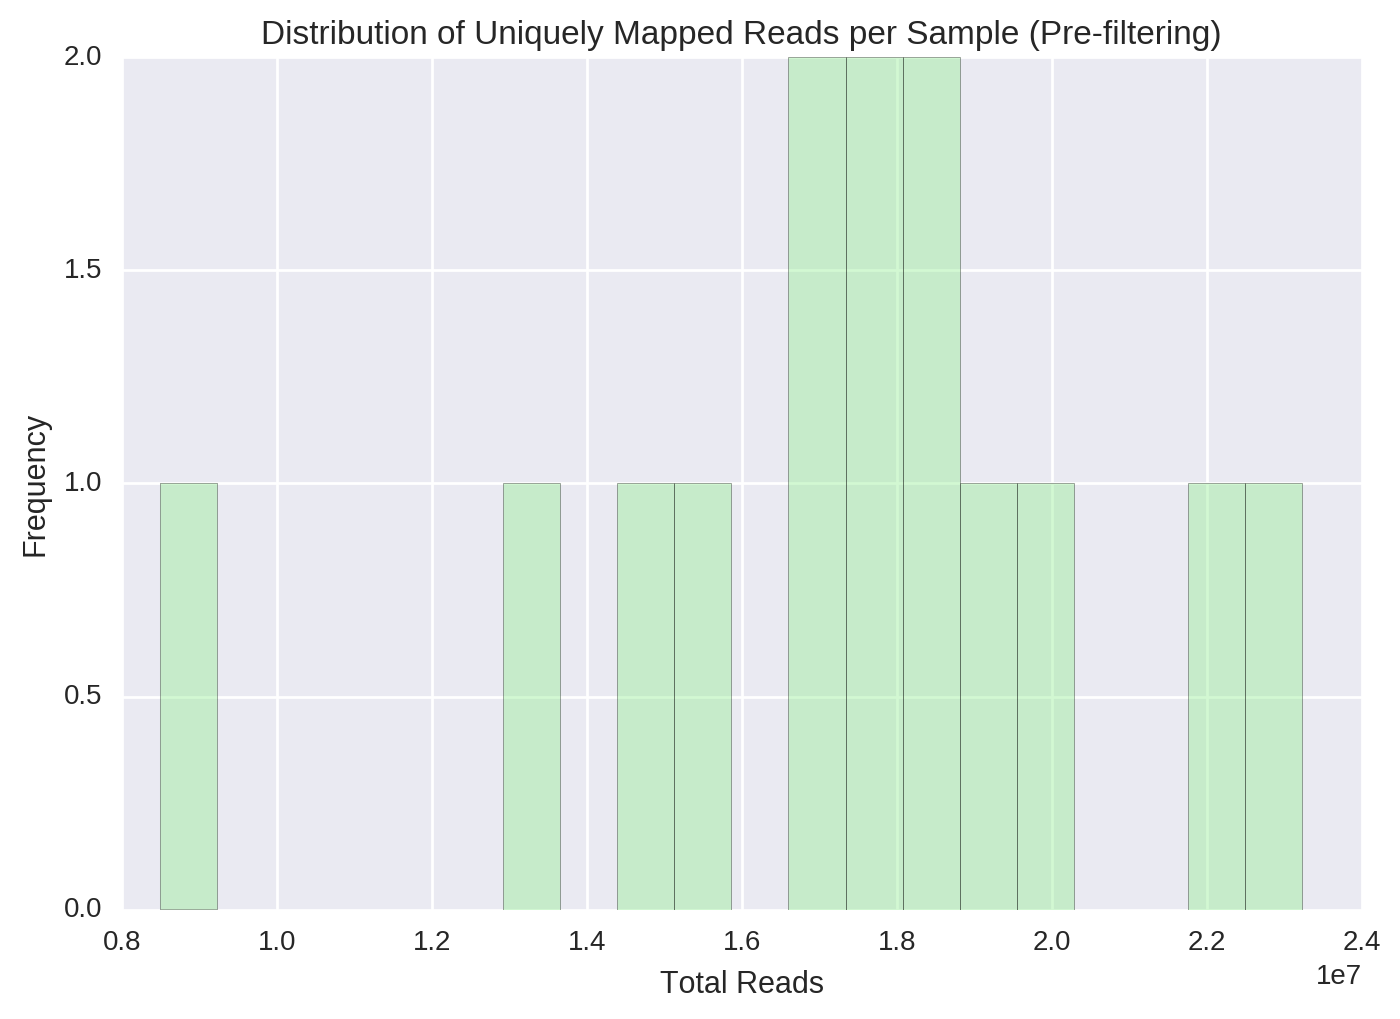

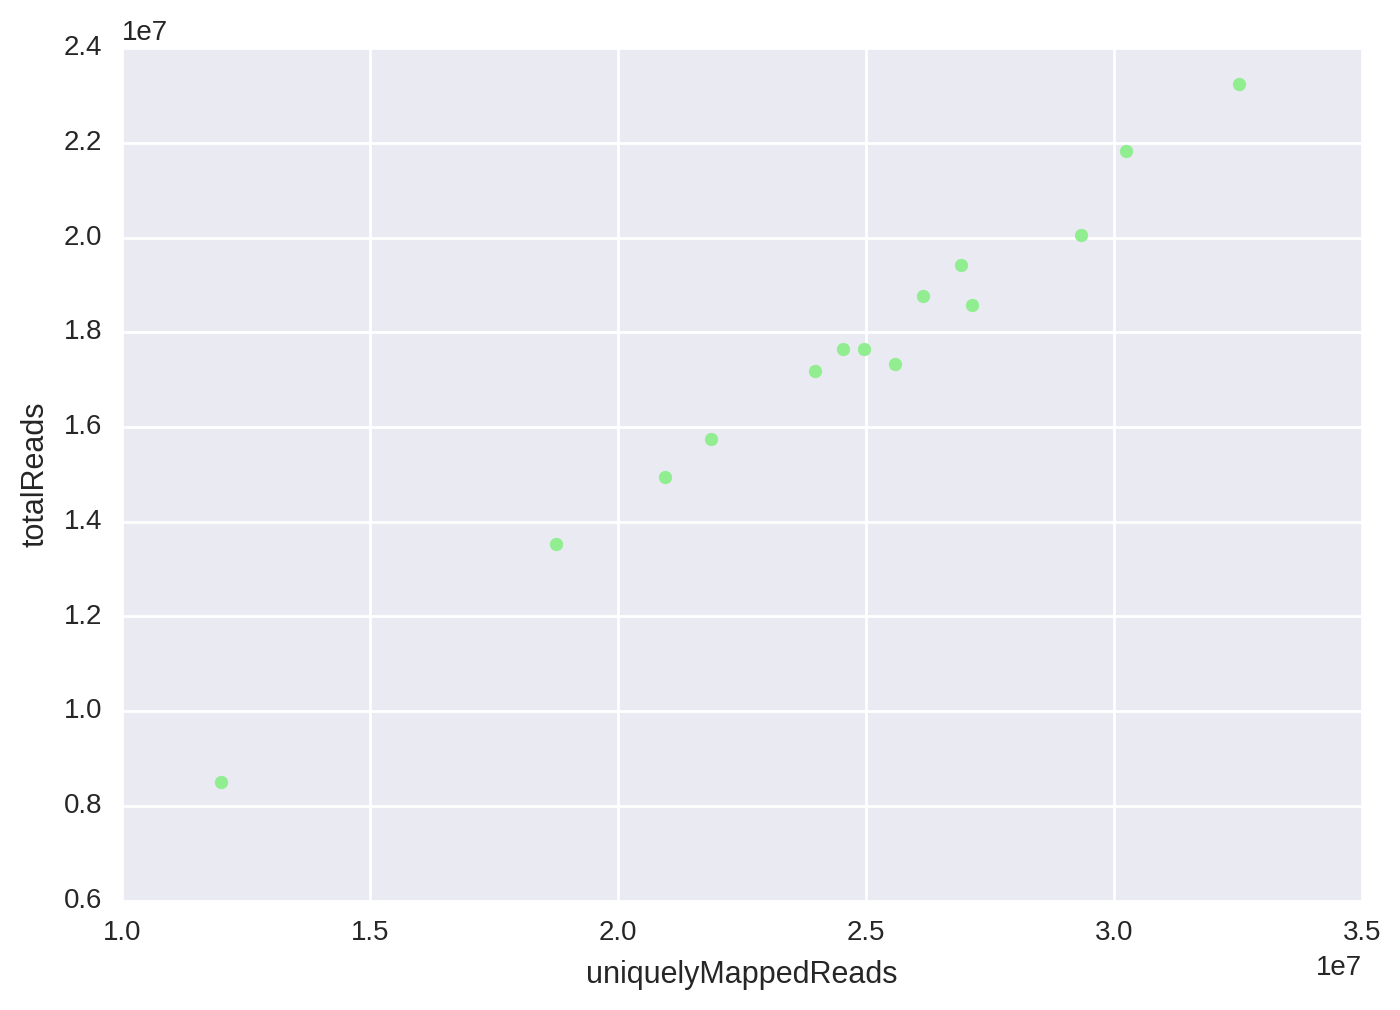

In [7]:
sns.distplot(filtered_summary_frame['uniquelyMappedFraction'], bins=20, kde=False, color='lightgreen')
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(filtered_summary_frame['uniquelyMappedReads'], bins=20, kde=False, color='lightgreen')
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Total Reads')
plt.ylabel('Frequency')
plt.show()

plt.scatter(filtered_summary_frame['totalReads'], y=filtered_summary_frame['uniquelyMappedReads'], color='lightgreen')
plt.ylabel('totalReads')
plt.xlabel('uniquelyMappedReads')
plt.show()






## Calculate Tag Counts and RPKM

In [375]:
%%capture
filteredTagDirectories = ' '.join([tagDirPath +x for x in filtered_summary_frame['originalName']])
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d $filteredTagDirectories > rpkm.tsv
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories > raw.tsv
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -d $filteredTagDirectories > reads.tsv

!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d ./tag_directories/* > rpkm_all.tsv



In [8]:
# read in RPKM values
rpkm_frame = pd.read_csv("rpkm.tsv",sep="\t")
columns = rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
rpkm_frame.columns = columns    
rpkm_frame['gene'] = [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]
columns = list(rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_frame = rpkm_frame[columns]

# read in tag counts
reads_frame = pd.read_csv("reads.tsv",sep="\t")
columns = reads_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "reads" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
reads_frame.columns = columns  
reads_frame['gene'] = [x.split("|")[0] for x in reads_frame['Annotation/Divergence']]
columns = list(reads_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
reads_frame = reads_frame[columns]

raw_frame = pd.read_csv("raw.tsv",sep="\t")
columns = raw_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "reads" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
raw_frame.columns = columns  
raw_frame['gene'] = [x.split("|")[0] for x in raw_frame['Annotation/Divergence']]
columns = list(raw_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
raw_frame = raw_frame[columns]

refseq_gene_mapping = dict(zip(rpkm_frame['refseq'].values, [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]))
gene_refseq_mapping = dict(zip([x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']], rpkm_frame['refseq'].values))
refseq_gene_mapping.update(dict(zip(reads_frame['refseq'].values, [x.split("|")[0] for x in reads_frame['Annotation/Divergence']])))
gene_refseq_mapping.update(dict(zip([x.split("|")[0] for x in reads_frame['Annotation/Divergence']], reads_frame['refseq'].values)))
refseq_gene_mapping.update(dict(zip(raw_frame['refseq'].values, [x.split("|")[0] for x in raw_frame['Annotation/Divergence']])))
gene_refseq_mapping.update(dict(zip([x.split("|")[0] for x in raw_frame['Annotation/Divergence']], raw_frame['refseq'].values)))




# get filtered rpkm values
filtered_rpkm_frame =  rpkm_frame[[x for x in rpkm_frame.columns if x in filtered_summary_frame['originalName'].values]]
columns = [originalName_simpleName_dict[x] for x in filtered_rpkm_frame.columns.values]
filtered_rpkm_frame.columns = columns
filtered_rpkm_frame.index = rpkm_frame.refseq.values
# get rid of genes that aren't expressed at all
filtered_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.sum(axis=1) > 1.0]

filtered_reads_frame = reads_frame[[x for x in reads_frame.columns if x in filtered_summary_frame['originalName'].values]]
columns = [originalName_simpleName_dict[x] for x in filtered_reads_frame.columns.values]
filtered_reads_frame.columns =columns 
filtered_reads_frame.index = reads_frame.refseq.values
                                   
# create frame that's easier to use with factor plots
pivoting_frame = filtered_rpkm_frame.transpose()
_refseq = []
_gene = []
_rpkm = []
_simplifiedName = list(pivoting_frame.index.values) * pivoting_frame.shape[1]
_treatment = list(filtered_summary_frame['simpleTreatment'].values) * pivoting_frame.shape[1]
for refseq in pivoting_frame.columns:
    gene = refseq_gene_mapping[refseq]
    for rpkm in pivoting_frame[refseq].values:
        _rpkm.append(rpkm)
        _refseq.append(refseq)
        _gene.append(gene.upper())
filtered_rpkm_plottingFrame = pd.DataFrame({
'refseq': _refseq,
'gene': _gene, 
'rpkm': _rpkm,
'simplifiedName': _simplifiedName,
'treatment': _treatment
})
del pivoting_frame
        
filtered_rpkm_plottingFrame_log = filtered_rpkm_plottingFrame.copy()
filtered_rpkm_plottingFrame_log['rpkm'] = np.log2(filtered_rpkm_plottingFrame.rpkm)

pivoting_frame = filtered_reads_frame.transpose()
_refseq = []
_gene = []
_reads = []
_simplifiedName = list(pivoting_frame.index.values) * pivoting_frame.shape[1]
_treatment = list(filtered_summary_frame['simpleTreatment'].values) * pivoting_frame.shape[1]
for refseq in pivoting_frame.columns:
    gene = refseq_gene_mapping[refseq]
    for rpkm in pivoting_frame[refseq].values:
        _reads.append(rpkm)
        _refseq.append(refseq)
        _gene.append(gene.upper())
filtered_reads_plottingFrame = pd.DataFrame({
'refseq': _refseq,
'gene': _gene, 
'reads': _reads,
'simplifiedName': _simplifiedName,
'treatment': _treatment
})
del pivoting_frame

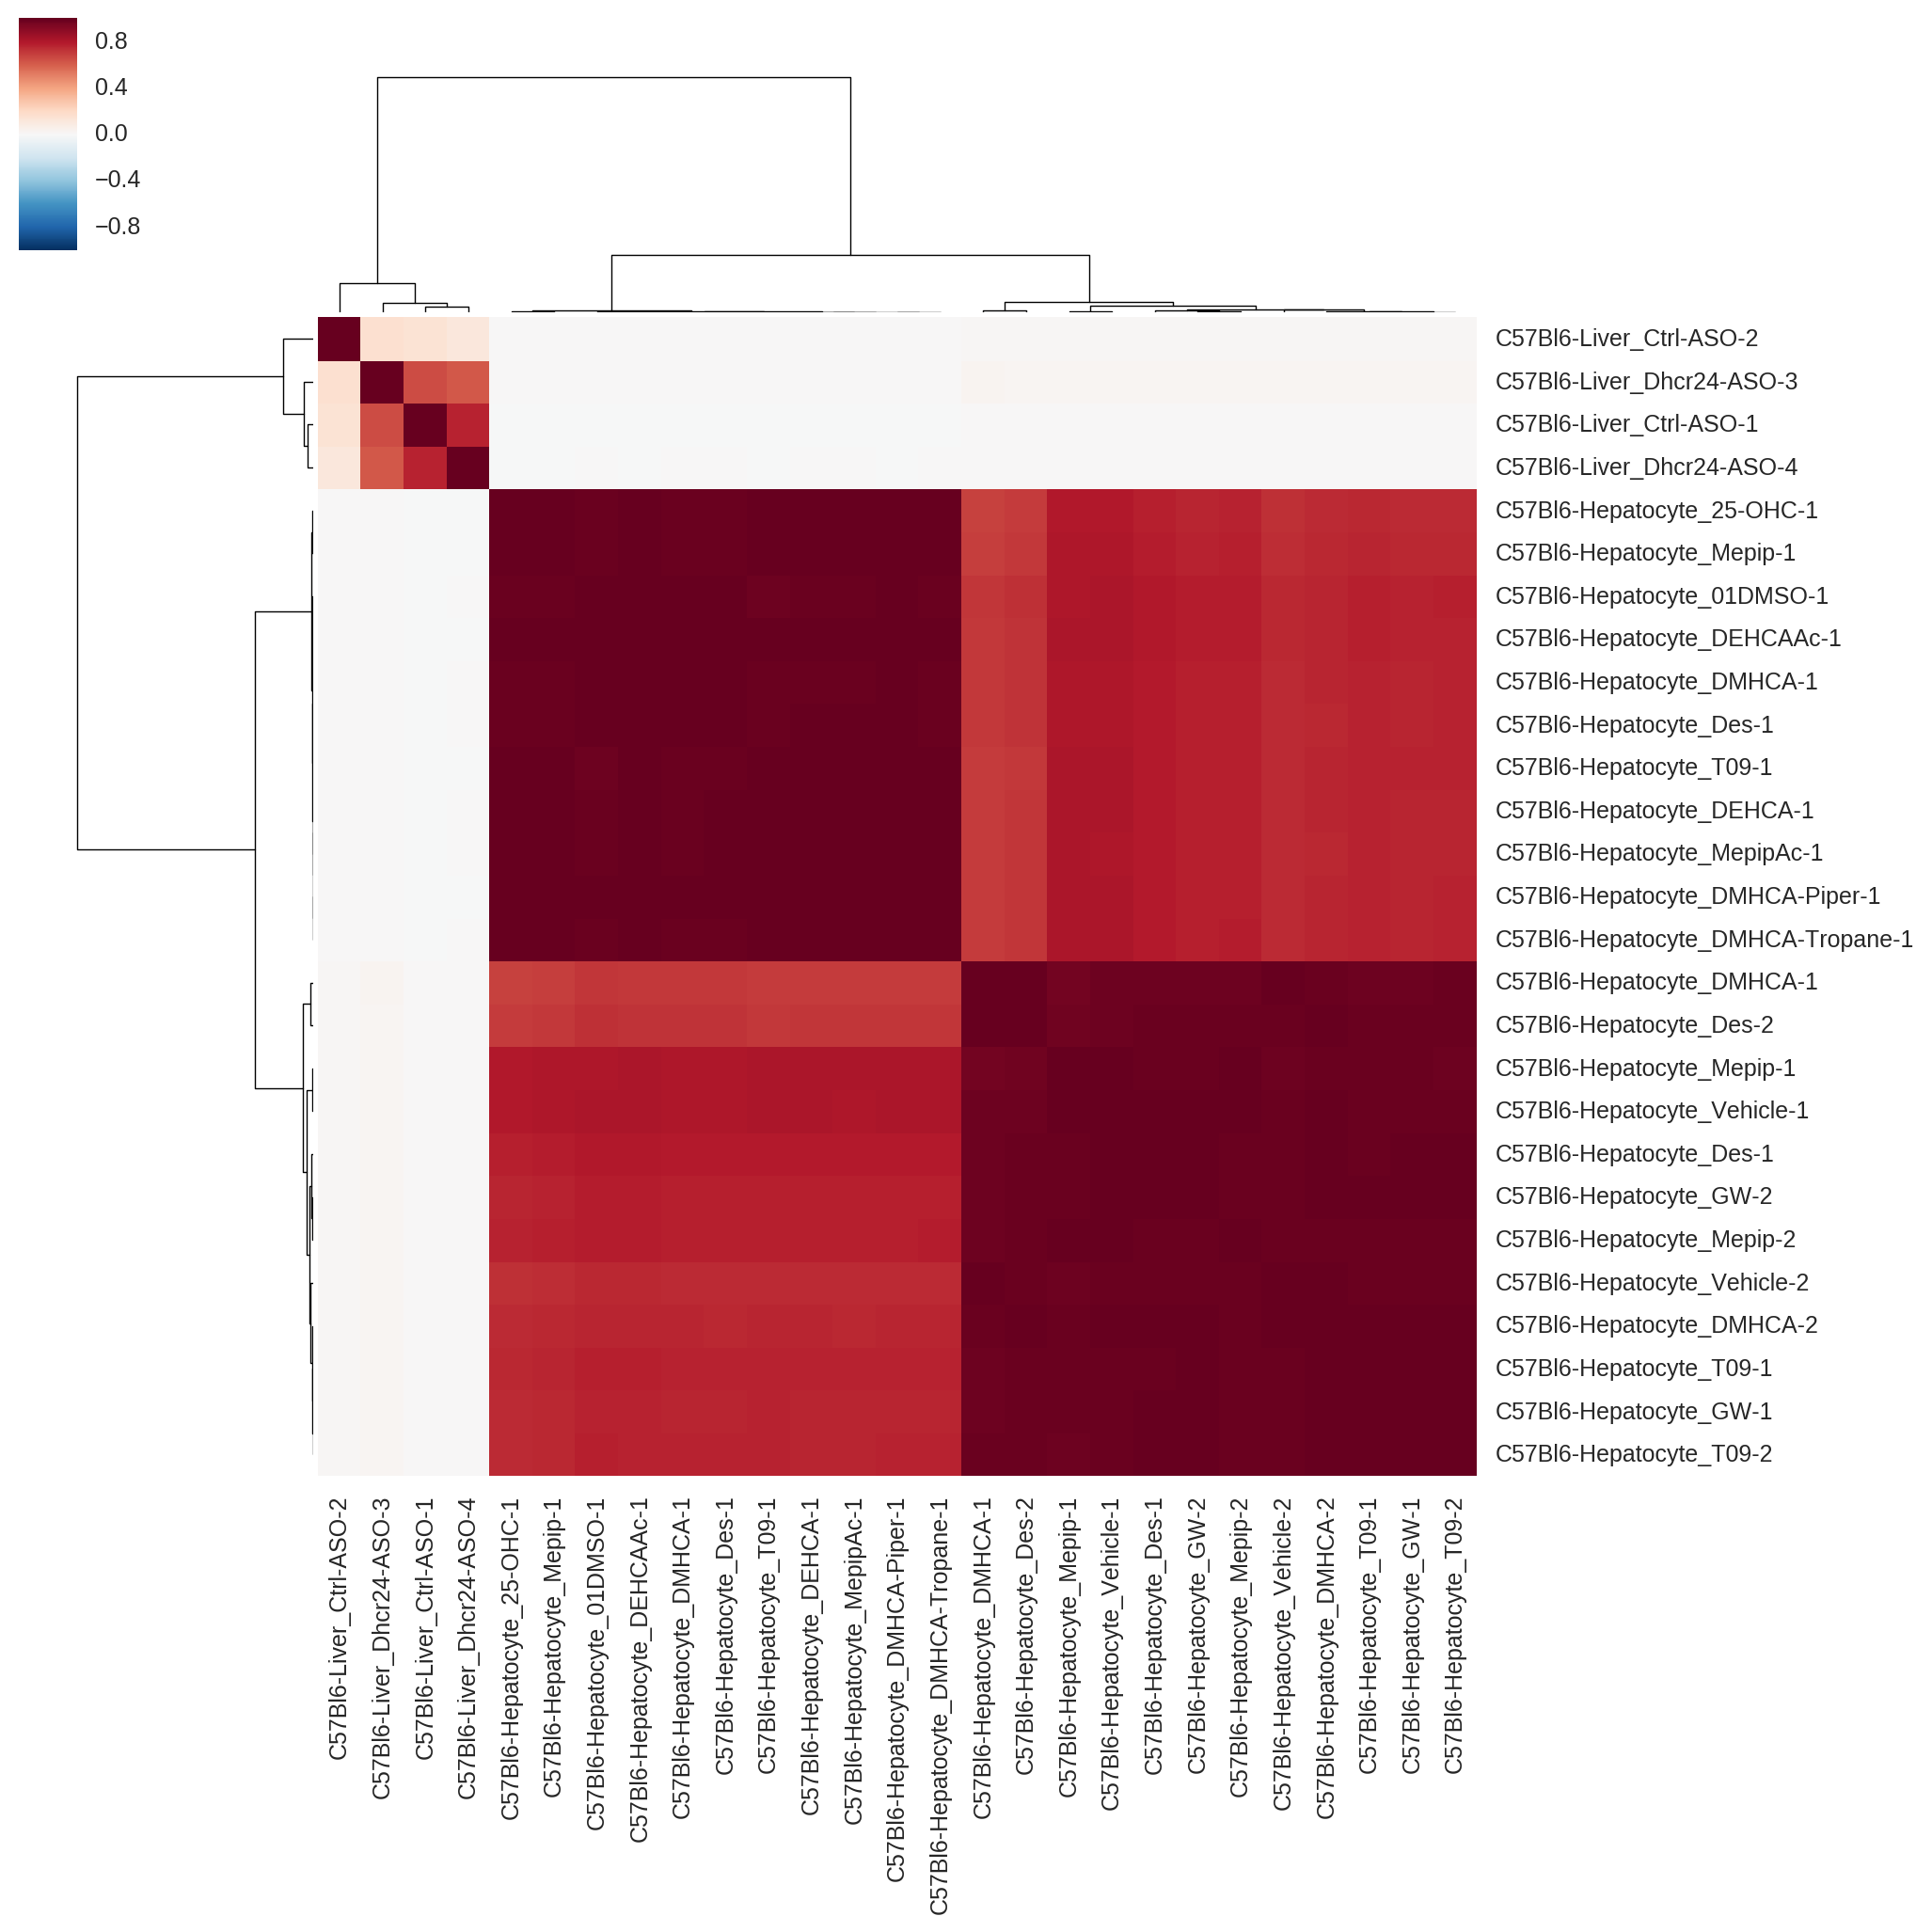

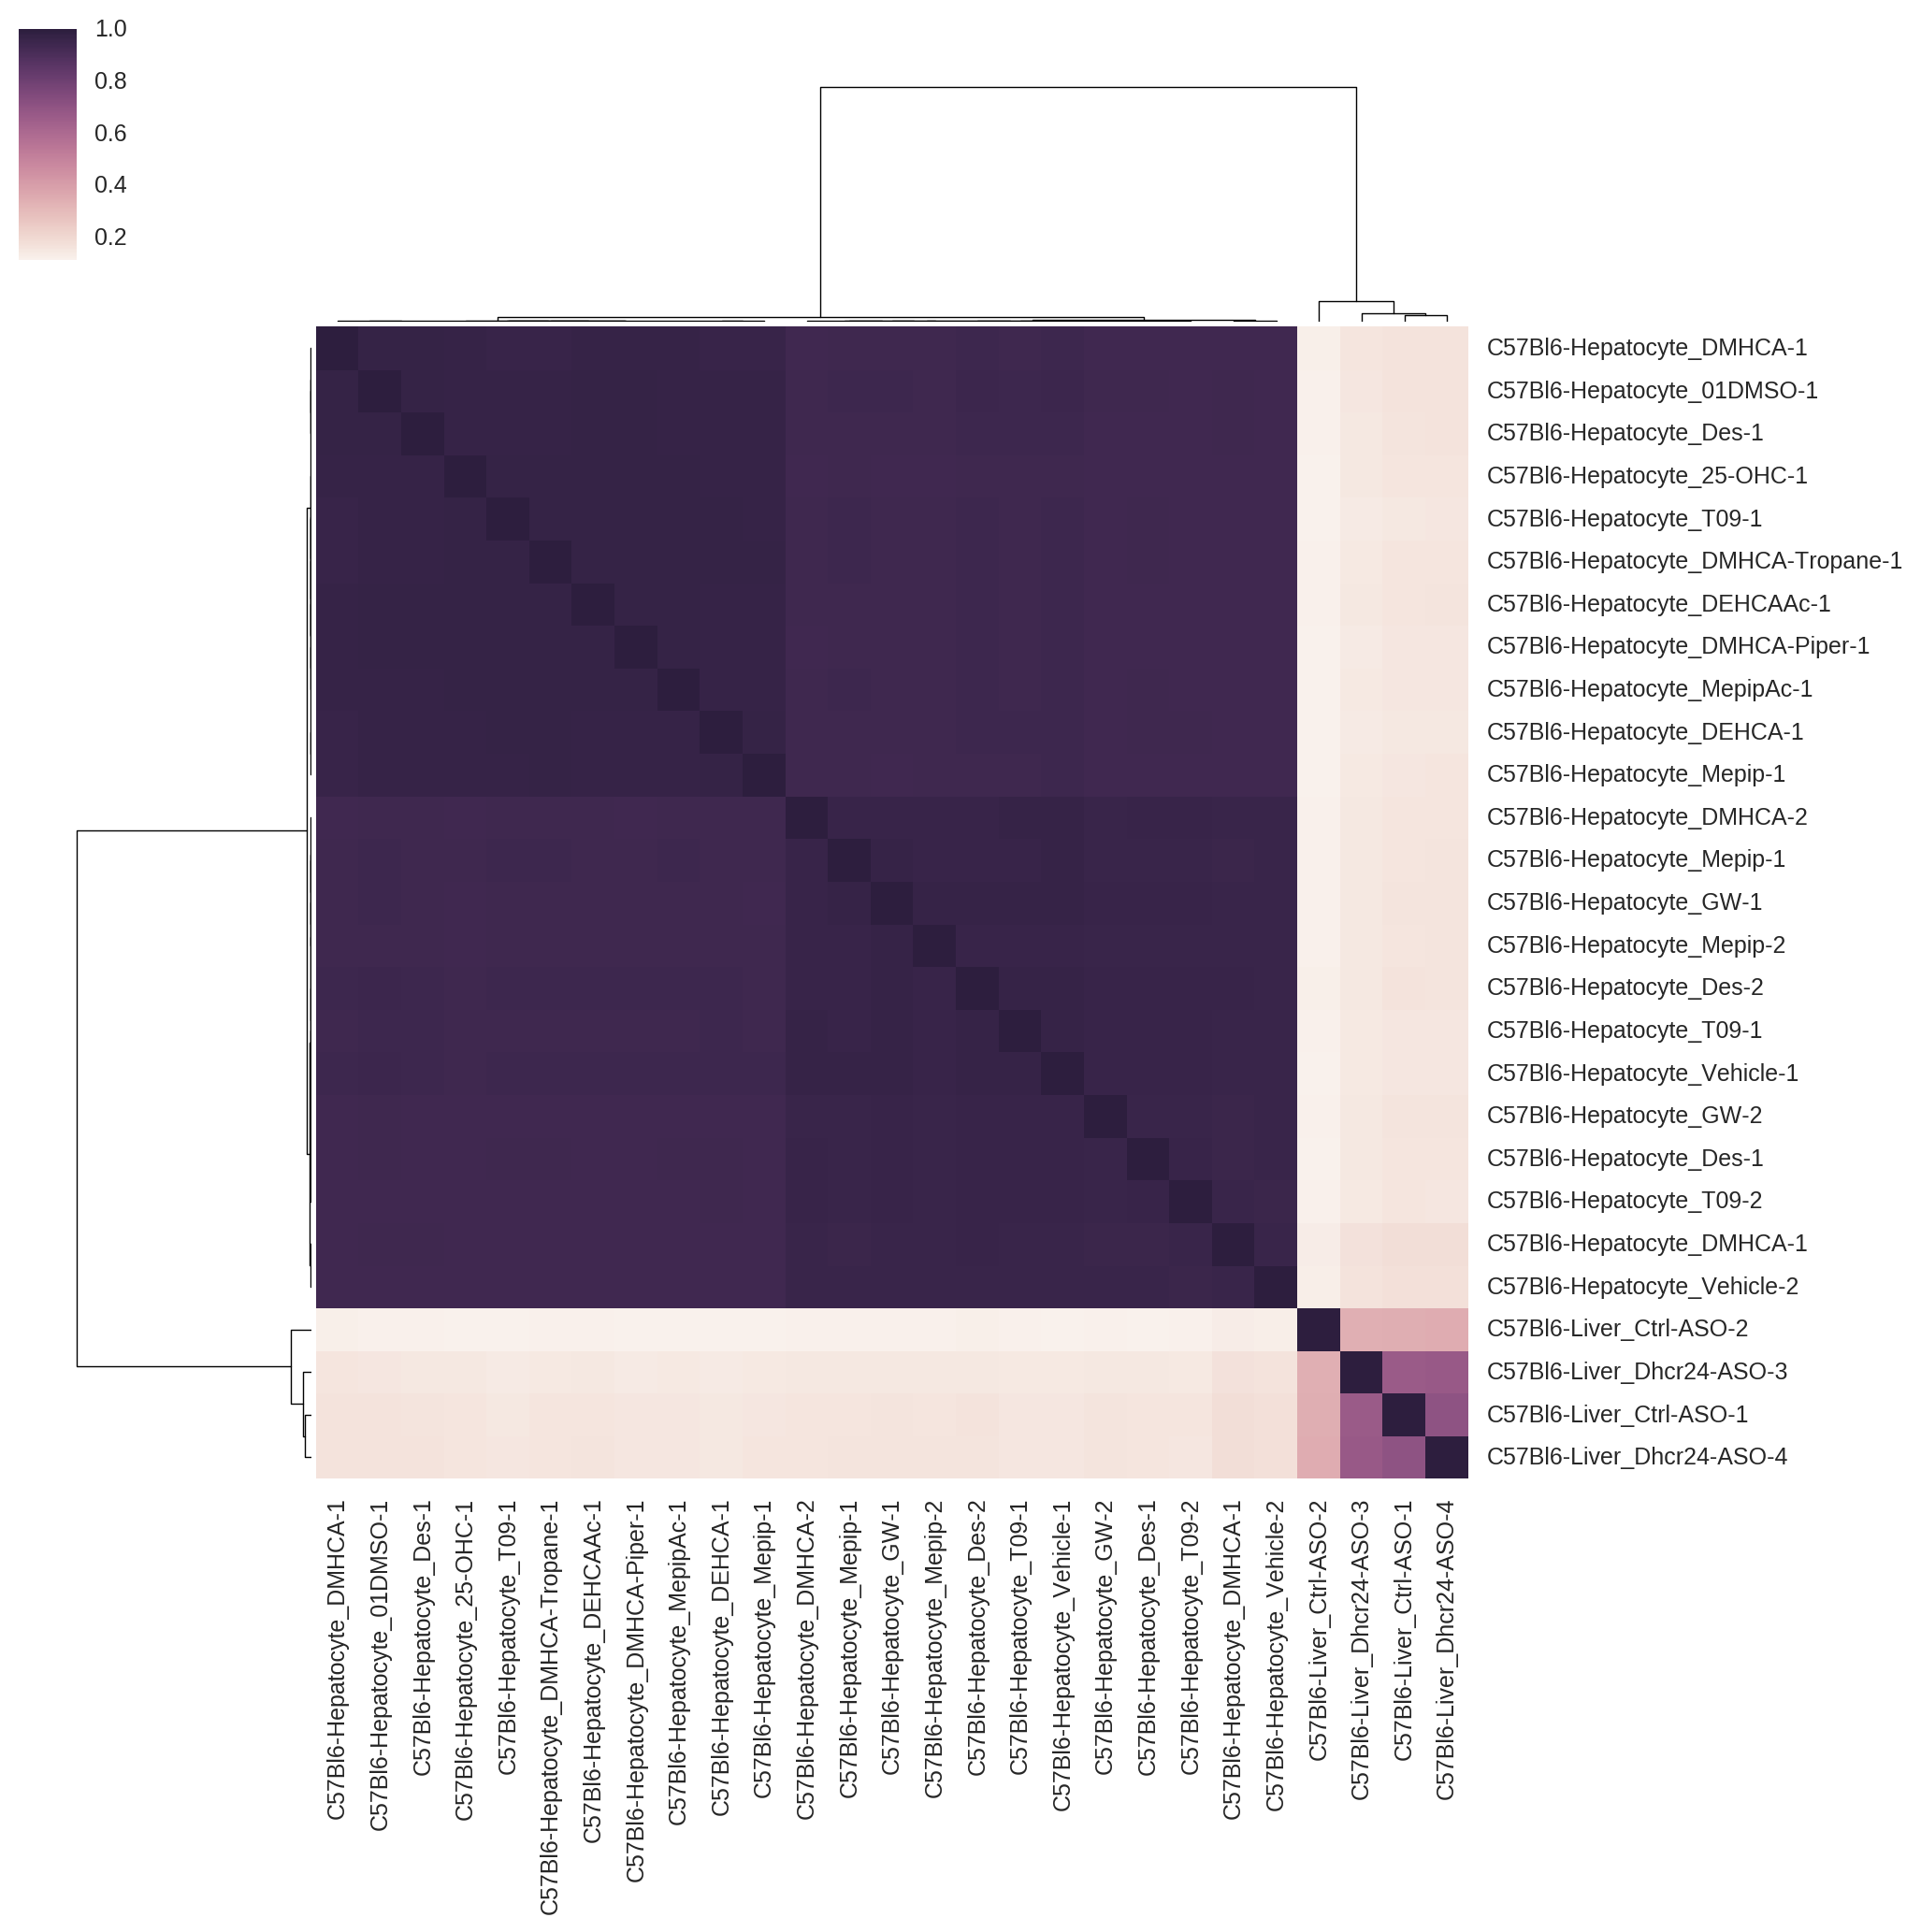

In [379]:
all_rpkm_frame = pd.read_csv("rpkm_all.tsv",sep="\t")
columns = all_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
all_rpkm_frame.columns = columns    
all_rpkm_frame['gene'] = [x.split("|")[0] for x in all_rpkm_frame['Annotation/Divergence']]
columns = list(all_rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
all_rpkm_frame = all_rpkm_frame[columns]
# all_rpkm_frame.columns = columns[:9] + ['_'.join(x.split('_')[0:3]).replace('Human-HMDM-','').replace('RNA_','') for x in columns[9:]]




### cluster samples according to correlation
samples = all_rpkm_frame.columns.values[9:]

labels = ['_'.join(x.split('_')[0:3]).replace('C57Bl4_','').replace('RNA_','') for x in columns[9:]]

spearman_matrix = np.zeros((len(samples), len(samples)))
pearson_matrix = np.zeros((len(samples), len(samples)))
for i in range(len(samples)):
    spearman_matrix[i][i]=1.0
    pearson_matrix[i][i]=1.0

for i in range(len(samples) - 1):
    for j in range(i+1, len(samples)):
        values_1 = all_rpkm_frame[samples[i]].values
        values_2 = all_rpkm_frame[samples[j]].values
        pearson, pearson_pval = scipy.stats.pearsonr(values_1,values_2)
        spearman, spearman_pval = scipy.stats.spearmanr(values_1,values_2)
        pearson_matrix[i][j] = pearson
        pearson_matrix[j][i] = pearson
        
        spearman_matrix[i][j] = spearman
        spearman_matrix[j][i] = spearman
        
        

sns.set_context('notebook', font_scale=0.9)
cg = sns.clustermap(pearson_matrix, xticklabels=labels, yticklabels=labels)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

cg = sns.clustermap(spearman_matrix, xticklabels=labels, yticklabels=labels)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

sns.set_context('notebook', font_scale=1.0)

In [380]:
if not os.path.isdir('scatter_plots'):
    os.mkdir('scatter_plots')
treatments = sorted(list(set(summary_frame.index)))
for i in range(len(treatments)):
    for j in range(i, len(treatments)):
        if i == j:
            print('***',treatments[i], treatments[j])
            columns = sorted(list(set(list(summary_frame.loc[treatments[i],'originalName']) + 
                                  list(summary_frame.loc[treatments[j],'originalName']))))
            data = np.log2(all_rpkm_frame.loc[:,columns] + 1)
            if len(columns) > 1:
                data = data[data.sum(axis=1) > 0.0]
                data.columns = [x.replace('C57Bl6-Hepatocyte_','').replace('RNA_','').replace('_EDM','') for x in columns]

                cg = sns.pairplot(data, 
                                  x_vars=sorted(set([x for x in data.columns.values if treatments[i][1] in x])),
                                  y_vars=sorted(set([x for x in data.columns.values if treatments[j][1] in x])),
                                  markers='.'
                                 )

                plt.savefig('./scatter_plots/' + '_'.join(treatments[i] + treatments[j]) + '_all.png')
                plt.close()

*** ('C57Bl6-Hepatocyte', 'DMHCA') ('C57Bl6-Hepatocyte', 'DMHCA')
*** ('C57Bl6-Hepatocyte', 'Des') ('C57Bl6-Hepatocyte', 'Des')
*** ('C57Bl6-Hepatocyte', 'GW') ('C57Bl6-Hepatocyte', 'GW')
*** ('C57Bl6-Hepatocyte', 'Mepip') ('C57Bl6-Hepatocyte', 'Mepip')
*** ('C57Bl6-Hepatocyte', 'T09') ('C57Bl6-Hepatocyte', 'T09')
*** ('C57Bl6-Hepatocyte', 'Vehicle') ('C57Bl6-Hepatocyte', 'Vehicle')


/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Run IDR

In [ ]:
# %%capture
sampleColumns = rpkm_frame.columns.values[9:]
originalName_simpleTreatment_dict = dict(zip(filtered_summary_frame['originalName'], filtered_summary_frame['simpleTreatment']))
originalName_strain_dict = dict(zip(filtered_summary_frame['originalName'], filtered_summary_frame['strain']))

conditions = " ".join([originalName_strain_dict[x] + '_' + originalName_simpleTreatment_dict[x] for x in sampleColumns])
!echo python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions
!python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions

In [10]:
idr_rpkm_frame = pd.read_csv('idr/idr_union_rpkm.tsv', sep='\t')

columns = idr_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = originalName_simpleName_dict[columns[i].split("/")[-1].split()[0]]
idr_rpkm_frame.columns = columns    
idr_rpkm_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_frame['Annotation/Divergence']]
columns = list(idr_rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
idr_rpkm_frame = idr_rpkm_frame[columns]
idr_rpkm_frame.index = idr_rpkm_frame['gene'].values
idr_rpkm_frame = idr_rpkm_frame.ix[:,9:]

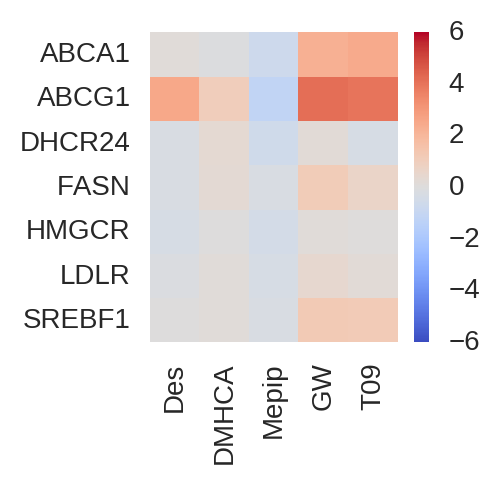

In [37]:
idr_rpkm_mean_frame = pd.DataFrame()
treatment_col_dict = {}
for col in idr_rpkm_frame.columns.values:
    treatment = col.split('_')[1]
    if not treatment in treatment_col_dict:
        treatment_col_dict[treatment] = [col]
    else:
        treatment_col_dict[treatment].append(col)
for treatment in treatment_col_dict:
    idr_rpkm_mean_frame[treatment] = np.mean(idr_rpkm_frame[treatment_col_dict[treatment]], axis=1)
idr_rpkm_mean_frame = idr_rpkm_mean_frame[['Vehicle', 'Des', 'DMHCA', 'Mepip', 'GW', 'T09']] 
idr_rpkm_mean_frame = idr_rpkm_mean_frame.sort()
genes = [x.upper() for x in ['Abca1',
'Abcg1',
'srebf1',
'LDLR',
'Dhcr24',
'Hmgcr',
'Fasn'
]]
plt.figure(figsize=(2,2))
fold_frame = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(genes)]
fold_frame = fold_frame.div(fold_frame['Vehicle'].values,axis=0)
fold_frame.drop('Vehicle', axis=1, inplace=True)
fold_frame = np.log2(fold_frame)
with sns.axes_style('whitegrid'):
    cg = sns.heatmap(fold_frame, cmap='coolwarm',vmax=6)
    plt.savefig('gene_heatmap.pdf', bbox_inches='tight')

## Calcuate Differential Expression with EdgeR

In [386]:
# %%capture
# use Homer to call differentially expressed genes with replicates
sample_condition_dict = dict(zip(filtered_summary_frame['originalName'], filtered_summary_frame['simpleTreatment']))
samples = raw_frame.columns[9:].values

conditions = " ".join([sample_condition_dict[x] for x in samples])
! getDiffExpression.pl raw.tsv $conditions > homer_diffExpresion.tsv


	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
Loading required package: limma
Loading required package: limma
Loading required package: limma
Loading required package: limma
Loading required package: limma
Loading required package: limma
Loading required package: limma
Loading required package: limma
Loading required package: limma
Loading required package: limma
Loading required package: limma
Loading required package: limma
Loading required package: limma
Loading required package: limma
Loading required package: limma


In [12]:
diffExpression_frame = pd.read_csv('homer_diffExpresion.tsv', sep='\t')
columns = diffExpression_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_frame.columns=columns
diffExpression_frame.index = diffExpression_frame.refseq.values
diffExpression_frame['gene'] = [x.split('|')[0] for x in diffExpression_frame['Divergence']]
columns = ['refseq', 'gene'] + [x for x in diffExpression_frame.columns if 'vs.' in x]
diffExpression_frame = diffExpression_frame[columns]

In [13]:
treatment_up_dict = {}
treatment_down_dict = {}

if not os.path.isdir('gene_ontology'):
    os.mkdir('gene_ontology')
    
fdr_threshold = 0.05

fdrColumns = [x for x in diffExpression_frame.columns if 'FDR' in x]


for c in fdrColumns:
    if 'Vehicle' in c:
        tokens = c.split()
        treatment1 = tokens[0]
        treatment2 = tokens[2]
        
        fc_column = c.replace('FDR', 'logFC')
        
        current_frame = diffExpression_frame[diffExpression_frame[c] < fdr_threshold][[c, fc_column, 'gene']]
        
        if treatment1 == 'Vehicle':
            up_genes = current_frame[current_frame[fc_column] > 0.0]['gene'].values
            down_genes = current_frame[current_frame[fc_column] < 0.0]['gene'].values
            treatment = treatment2
        else:
            treatment = treatment1
            down_genes = current_frame[current_frame[fc_column] > 0.0]['gene'].values
            up_genes = current_frame[current_frame[fc_column] < 0.0]['gene'].values
        
        treatment_up_dict[treatment] = up_genes
        treatment_down_dict[treatment] = down_genes
        
        # wrtite genes for gene ontology
        up_file = open('./gene_ontology/' + treatment + '_up.txt', 'w')
        for g in up_genes:
            up_file.write(g.upper() + '\n')
        up_file.close()
        
        down_file = open('./gene_ontology/' + treatment + '_down.txt', 'w')
        for g in down_genes:
            down_file.write(g.upper() + '\n')
        print(treatment, len(up_genes), len(down_genes))
        down_file.close()
        

DMHCA 0 0
Des 0 0
GW 59 30
Mepip 0 0
T09 3 0


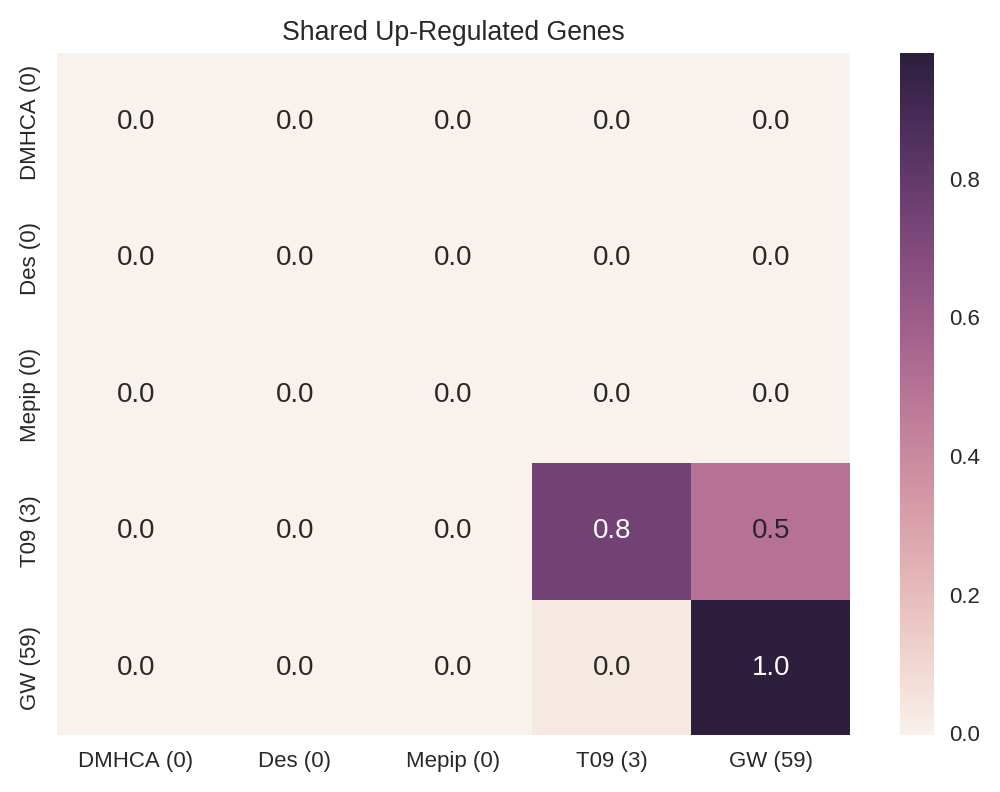

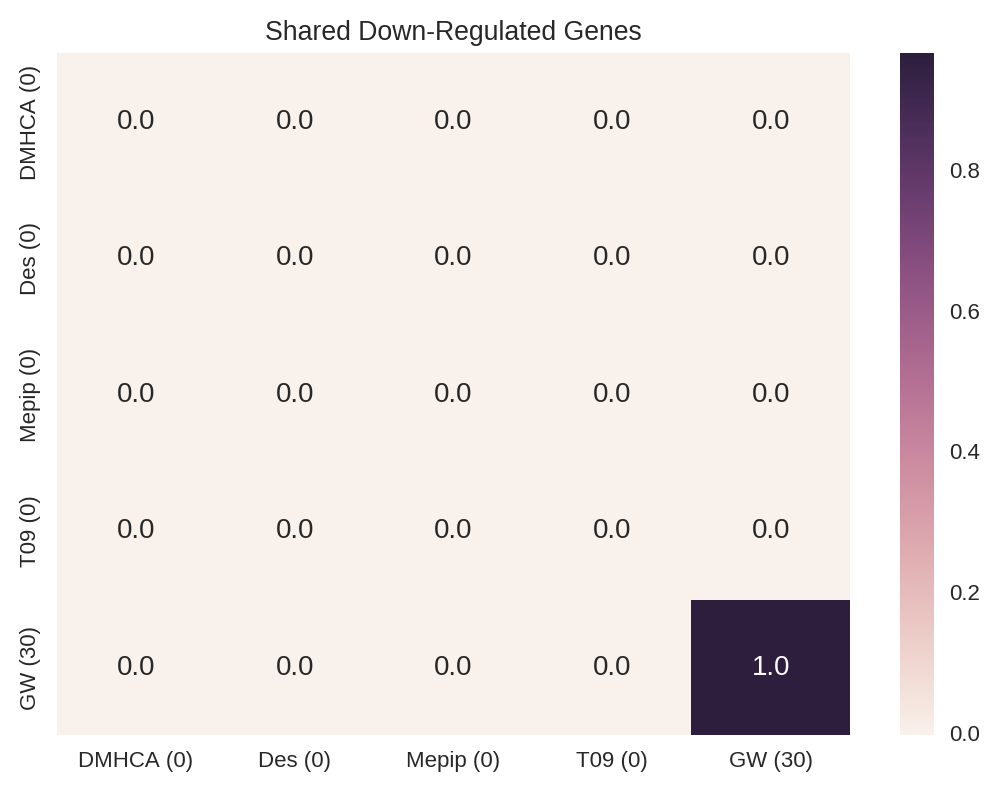

In [413]:
if not os.path.isdir('./diffExpressed_vennDiagrams'):
    os.mkdir('./diffExpressed_vennDiagrams')
    
# get up and down regulated genes versus vehicle for each condition
# create heat map visualization for how many differentially expressed genes are shared
treatments = sorted(treatment_up_dict.keys())

treatments_up = [x[0] for x in sorted(tuple(zip(treatments, 
                                                [len(treatment_up_dict[x]) for x in treatments])), 
                                      key=lambda x: x[1])]
treatments_down = [x[0] for x in sorted(tuple(zip(treatments, 
                                                [len(treatment_down_dict[x]) for x in treatments])), 
                                      key=lambda x: x[1])]

treatment_up_index_dict = dict(zip(treatments_up , range(len(treatments))))

treatment_down_index_dict = dict(zip(treatments_down , range(len(treatments))))
  
up_matrix = np.zeros((len(treatments), len(treatments)))
down_matrix = np.zeros((len(treatments), len(treatments)))

for i in range(len(treatments) - 1):
    for j in range(i+1, len(treatments)):
        treatment1 = treatments[i]
        treatment2 = treatments[j]
        
        ind1_up = treatment_up_index_dict[treatment1]
        ind2_up = treatment_up_index_dict[treatment2]
        ind1_down = treatment_down_index_dict[treatment1]
        ind2_down =treatment_down_index_dict[treatment2]
        
        num_intersecting_up = len(set(treatment_up_dict[treatment1]).intersection(set(treatment_up_dict[treatment2])))
        num_intersecting_down = len(set(treatment_down_dict[treatment1]).intersection(set(treatment_down_dict[treatment2])))
        up_matrix[ind1_up][ind2_up] = num_intersecting_up
        up_matrix[ind2_up][ind1_up] = num_intersecting_up
        down_matrix[ind1_down][ind2_down] = num_intersecting_down
        down_matrix[ind2_down][ind1_down] = num_intersecting_down

# fill in diagonals
for i in range(len(treatments)):
        treatment = treatments[i]
        ind_up = treatment_up_index_dict[treatment]
        ind_down = treatment_down_index_dict[treatment]
        num_up = len(set(treatment_up_dict[treatment]))
        num_down = len(set(treatment_down_dict[treatment]))
        up_matrix[ind_up][ind_up] = num_up
        down_matrix[ind_down][ind_down] = num_down


up_labels = [x + ' (' +str(len(treatment_up_dict[x])) + ')' for x in treatments_up]
down_labels = [x + ' (' +str(len(treatment_down_dict[x])) + ')' for x in treatments_down]


# convert matrices to data frames
up_frame = pd.DataFrame(up_matrix).astype(int)
up_frame.columns = up_labels
up_frame.index = up_labels

down_frame = pd.DataFrame(down_matrix).astype(int)
down_frame.columns = down_labels
down_frame.index = down_labels

up_frame = up_frame.div(up_frame.max(axis=1) + 1, axis=0)
down_frame = down_frame.div(down_frame.max(axis=1) + 1, axis=0)

sns.heatmap(up_frame, annot=True, fmt='.1f')
plt.title("Shared Up-Regulated Genes")
plt.savefig('diffExpressed_vennDiagrams/diffExpressed_matrix_up.png')
plt.show()

sns.heatmap(down_frame, annot=True, fmt='.1f')
plt.title("Shared Down-Regulated Genes")
plt.savefig('diffExpressed_vennDiagrams/diffExpressed_matrix_down.png')
plt.show()

In [420]:
### make Venn Diagrams
if not os.path.isdir('./diffExpressed_vennDiagrams'):
    os.mkdir('./diffExpressed_vennDiagrams')
treatments = sorted(treatment_up_dict.keys())

for i in range(len(treatments) - 1):
    for j in range(i+1, len(treatments)):
        treatment1 = treatments[i]
        treatment2 = treatments[j]

        up_1 = set(treatment_up_dict[treatment1])
        up_2 = set(treatment_up_dict[treatment2])
        
        down_1 = set(treatment_down_dict[treatment1])
        down_2 = set(treatment_down_dict[treatment2])
        
        venn2([up_1, up_2], set_labels=[treatment1, treatment2])
        plt.savefig('./diffExpressed_vennDiagrams/' + treatment1 + '_' + treatment2 + '_up_vs_veh_venn.png')
        plt.close()
        
        venn2([down_1, down_2], set_labels=[treatment1, treatment2])
        plt.savefig('./diffExpressed_vennDiagrams/' + treatment1 + '_' + treatment2 + '_down_vs_veh_venn.png')
        plt.close()

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib_venn-0.9-py3.4.egg/matplotlib_venn/_venn2.py:46: UserWarning: Both circles have zero area
/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib_venn-0.9-py3.4.egg/matplotlib_venn/_venn3.py:422: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


## Gene Ontology Enrichment

In [402]:
outFile = open('./gene_ontology/background.txt', 'w')
for g in raw_frame[raw_frame.ix[:,9:].sum(axis=1) > 16.0]['gene'].values:
    outFile.write(g.upper() + '\n')
outFile.close()

for f in os.listdir('./gene_ontology/'):
    if not 'background' in f and not 'result' in f and'.txt' in f:
        out_name = f.replace('.txt', '_result.txt')
#         os.system('/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/' 
#                   + f +' ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/' + out_name)
        print('/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/' 
                  + f +' ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/' + out_name + ' &')




/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/Des_down.txt ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/Des_down_result.txt &
/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/DMHCA_down.txt ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/DMHCA_down_result.txt &
/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/Des_up.txt ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/Des_up_result.txt &
/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/Mepip_down.txt ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/Mepip_down_result.txt &
/bioinformatics/software/anaconda2.7/bin/pyt

In [14]:
fdr_threshold = 0.05
p_threshold = 0.05
term_tuples = []
terms = []
treatments = []
for f in os.listdir('./gene_ontology/'):
#     if 'result' in f and 'up' in f and not 'mepip' in f.lower():
    if 'result' in f and 'up' in f :
        with open('./gene_ontology/' + f) as data:
            data = data.readlines()
        if len(data):
            results = pd.read_csv('./gene_ontology/' + f ,sep='\t', skiprows=2)
            treatment = f.split('_')[0]
            treatments.append(treatment)
            significant_results = results[results['p_bonferroni'] < p_threshold]

            # seperate enriched and purified results
            enriched_results = significant_results[significant_results['enrichment']=='e']

            purified_results= significant_results[significant_results['enrichment']=='p']
            terms = terms + list(enriched_results['description'].values)
            term_tuples = term_tuples +list(zip(enriched_results['id'].values,
                                                enriched_results['description'].values, 
                                                enriched_results['p_bonferroni'].values, 
                                                [treatment] * significant_results.shape[0]))
            print(treatment, enriched_results.shape)


terms = sorted(list(set(terms)))
treatments=sorted(treatments)
# treatments.remove('1um-Mepip')
term_id_dict = dict(zip([x[1] for x in term_tuples],
                       [x[0] for x in term_tuples]))
term_index_dict = dict(zip(terms, range(len(terms))))

treatment_index_dict = dict(zip(treatments, range(len(treatments))))
counter = 0
matrix = np.ones((len(terms), len(treatments)))
for t in term_tuples:
    matrix[term_index_dict[t[1]]][treatment_index_dict[t[3]]] = t[2]
up_frame = pd.DataFrame(matrix, columns=treatments, index=terms)
up_frame['id'] = [term_id_dict[x] for x in up_frame.index.values]
# cg = sns.clustermap(-1* np.log10(up_frame.ix[:,:-1] + 0.0000001),
#                    col_cluster=False)
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);


# hm = cg.ax_heatmap.get_position()
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=5, rotation=0)
# plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), fontsize=10, rotation=90)


# # cg.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*0.5, hm.height*2.25])
# # col = cg.ax_row_dendrogram.get_position()
# # cg.ax_row_dendrogram.set_position([col.x0, col.y0, col.width, col.height*2.25])
# plt.savefig('./gene_ontology/significant_terms_up.pdf', bbox_inches='tight')
# sns.set_context('notebook', font_scale=1)
# plt.title('Up-Regulated GO Terms')
# plt.show()

term_tuples = []
terms = []
treatments = []
for f in os.listdir('./gene_ontology/'):
#     if 'result' in f and 'down' in f and not 'mepip' in f.lower():
    if 'result' in f and 'down' in f:
        with open('./gene_ontology/' + f) as data:
            data = data.readlines()
        if len(data):
            results = pd.read_csv('./gene_ontology/' + f ,sep='\t', skiprows=2)
            treatment = f.split('_')[0]
            treatments.append(treatment)
            significant_results = results[results['p_bonferroni'] < p_threshold]

            # seperate enriched and purified results
            enriched_results = significant_results[significant_results['enrichment']=='e']

            purified_results= significant_results[significant_results['enrichment']=='p']
            terms = terms + list(enriched_results['description'].values)
            term_tuples = term_tuples +list(zip(enriched_results['id'].values,
                                                enriched_results['description'].values, 
                                                enriched_results['p_bonferroni'].values, 
                                                [treatment] * significant_results.shape[0]))
            print(treatment, enriched_results.shape)


terms = sorted(list(set(terms)))
treatments=sorted(treatments)
# treatments.remove('1um-Mepip')
term_id_dict = dict(zip([x[1] for x in term_tuples],
                       [x[0] for x in term_tuples]))
term_index_dict = dict(zip(terms, range(len(terms))))

treatment_index_dict = dict(zip(treatments, range(len(treatments))))
counter = 0
matrix = np.ones((len(terms), len(treatments)))
for t in term_tuples:
    matrix[term_index_dict[t[1]]][treatment_index_dict[t[3]]] = t[2]
down_frame = pd.DataFrame(matrix, columns=treatments, index=terms)
down_frame['id'] = [term_id_dict[x] for x in down_frame.index.values]

# cg = sns.clustermap(-1* np.log10(down_frame.ix[:,:-1] + 0.0000001),
#                    col_cluster=False)
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);


# hm = cg.ax_heatmap.get_position()
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=5, rotation=0)
# plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), fontsize=10, rotation=90)


# cg.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*0.5, hm.height*2.25])
# col = cg.ax_row_dendrogram.get_position()
# cg.ax_row_dendrogram.set_position([col.x0, col.y0, col.width, col.height*2.25])
# plt.savefig('./gene_ontology/significant_terms_down.pdf', bbox_inches='tight')
# sns.set_context('notebook', font_scale=1)
# plt.title('Down-regulated GO Terms')
# plt.show()




# save to text and spreadsheets
# labels = up_frame.index.values
# features = up_frame.ix[:,0:5]
# distances = scipy.spatial.distance.pdist(features)
# linkage = scipy.cluster.hierarchy.linkage(distances, method='complete')
# dendrogram = scipy.cluster.hierarchy.dendrogram(linkage, labels = labels);
# plt.close()
# up_frame = up_frame.ix[dendrogram['ivl'],:]
# labels = down_frame.index.values
# features = down_frame.ix[:,0:5]
# distances = scipy.spatial.distance.pdist(features)
# linkage = scipy.cluster.hierarchy.linkage(distances, method='complete')
# dendrogram = scipy.cluster.hierarchy.dendrogram(linkage, labels = labels);
# plt.close()
# down_frame = down_frame.ix[dendrogram['ivl'],:]

up_frame=up_frame[[x for x in  up_frame.columns if not '30' in x]]
down_frame=down_frame[[x for x in  down_frame.columns if not '30' in x]]

# save go terms
up_frame.to_csv('go_terms_up.tsv', sep='\t')
down_frame.to_csv('go_terms_down.tsv', sep='\t')
out_file = open('go_ids_up.txt', 'w')
for id in up_frame['id'].values:
    out_file.write(id.strip() + '\n')
out_file.close()

out_file = open('go_ids_down.txt', 'w')
for id in down_frame['id'].values:
    out_file.write(id.strip() + '\n')
out_file.close()

T09 (0, 10)
GW (50, 10)
GW (0, 10)


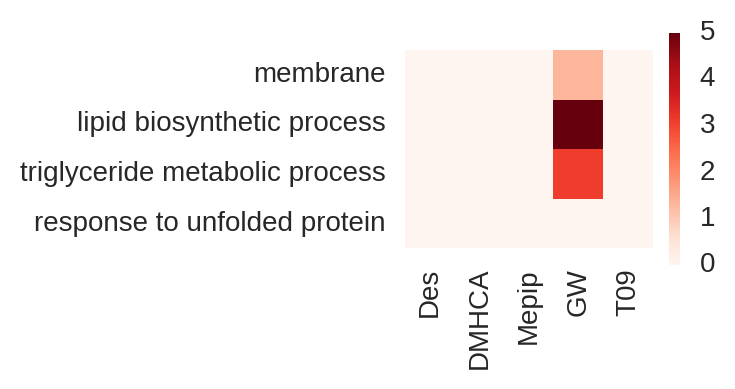

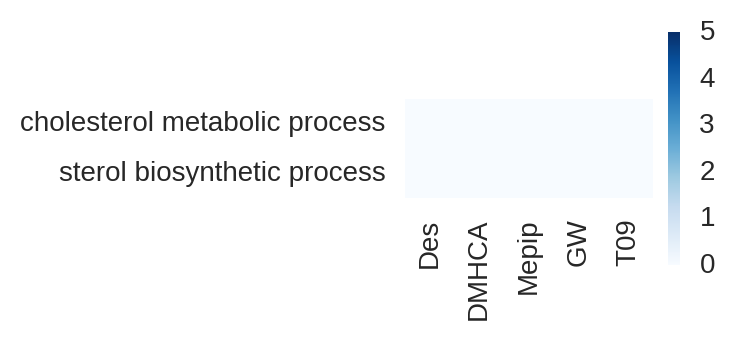

In [45]:
for t in ['membrane',
                'lipid biosynthetic process',
                'triglyceride metabolic process',
                'response to unfolded protein']:
    if not t in up_frame.index.values:
        up_frame = up_frame.T
        up_frame[t]= 1.0
        up_frame = up_frame.T
    

data = pd.DataFrame(up_frame.ix[['membrane',
                'lipid biosynthetic process',
                'triglyceride metabolic process',
                'response to unfolded protein'],
                   ['Des',
                    'DMHCA',
                    'Mepip', 
                    'GW', 
                    'T09']])
data = data.fillna(1)
plt.figure(figsize=(2,1.5))
with sns.axes_style('whitegrid'):
    sns.heatmap(-1*np.log10(data.astype(float)), 
                cmap='Reds',
                square=True,
               vmax=5)
plt.savefig('./gene_ontology/significant_terms_up.pdf', bbox_inches='tight')
plt.show()

for t in ['cholesterol metabolic process',
                'sterol biosynthetic process',
                       ]:
    if not t in down_frame.index.values:
        down_frame = down_frame.T
        down_frame[t]= 1.0
        down_frame = down_frame.T
        
        
data = down_frame.ix[['cholesterol metabolic process',
                'sterol biosynthetic process',
                       ],
                     ['Des',
                    'DMHCA',
                    'Mepip', 
                    'GW', 
                    'T09']]
data = data.fillna(1)

plt.figure(figsize=(2,1.5))
with sns.axes_style('whitegrid'):
    sns.heatmap(-1*np.log10(data.astype(float)), 
                cmap='Blues',
                square=True,
               vmax=5)
plt.savefig('./gene_ontology/significant_terms_down.pdf', bbox_inches='tight')


## Bar Plots

In [394]:
set(filtered_rpkm_plottingFrame['treatment'].values)

{'DMHCA', 'Des', 'GW', 'Mepip', 'T09', 'Vehicle'}

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


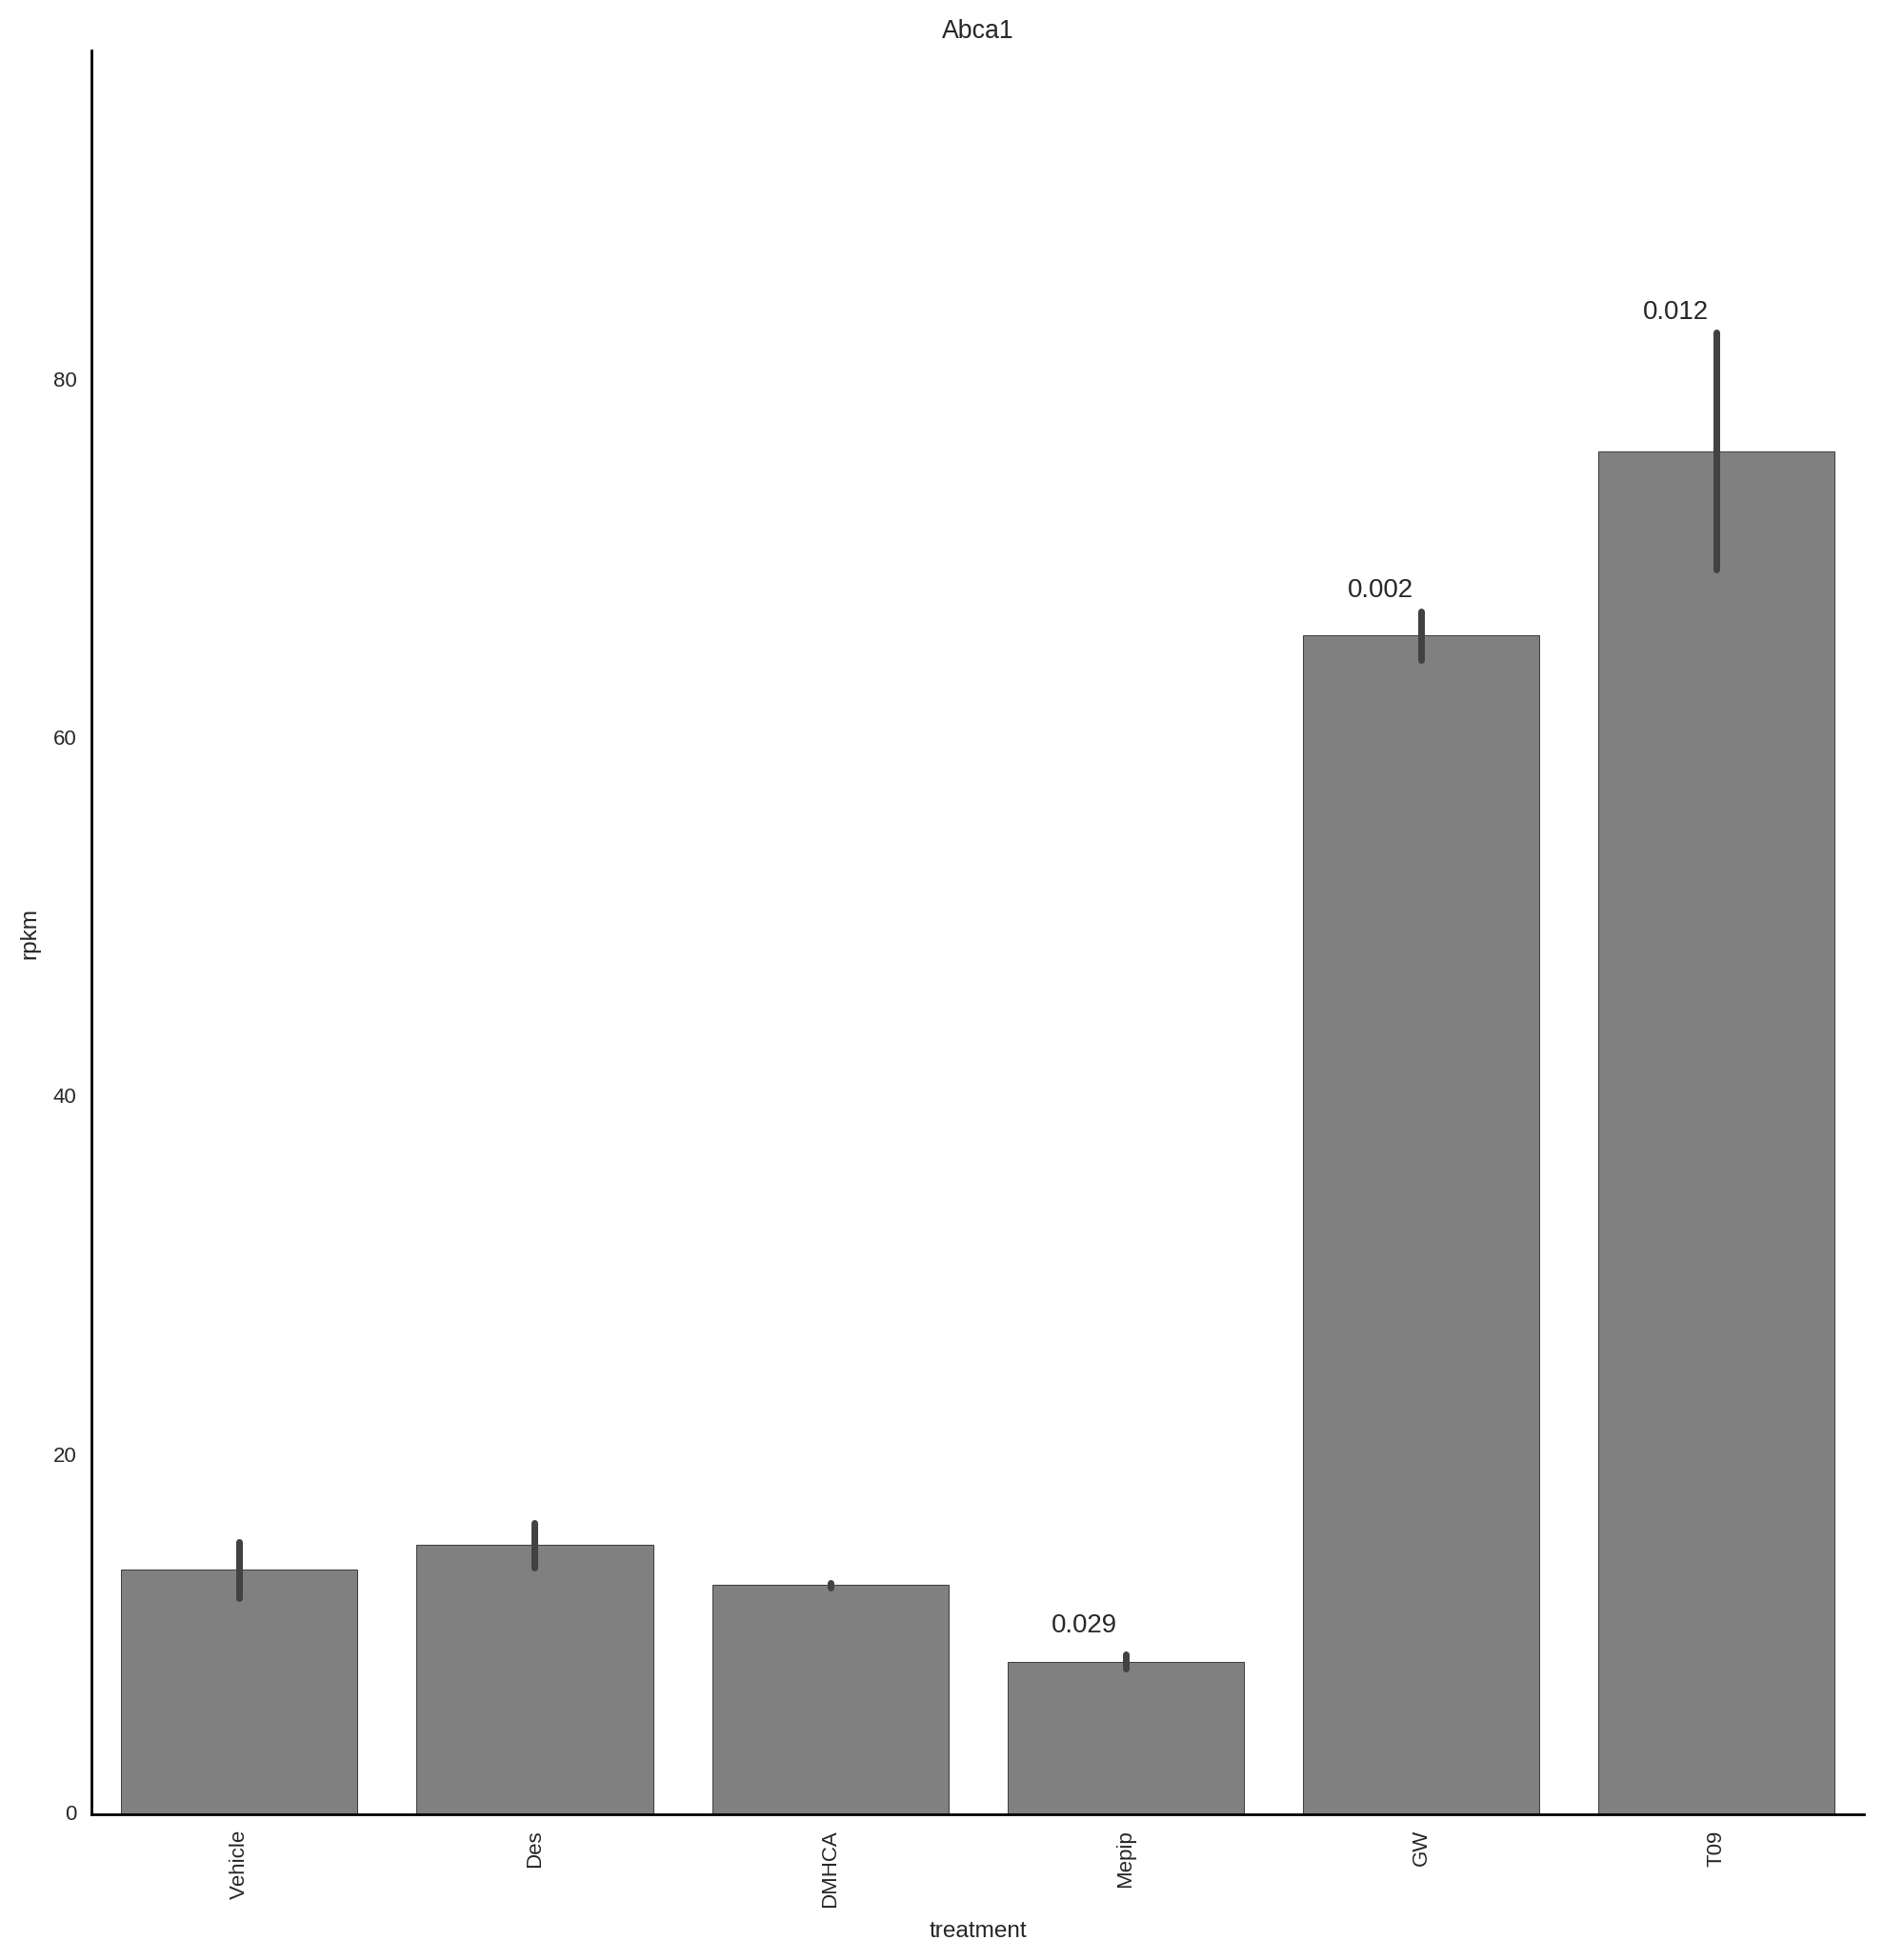

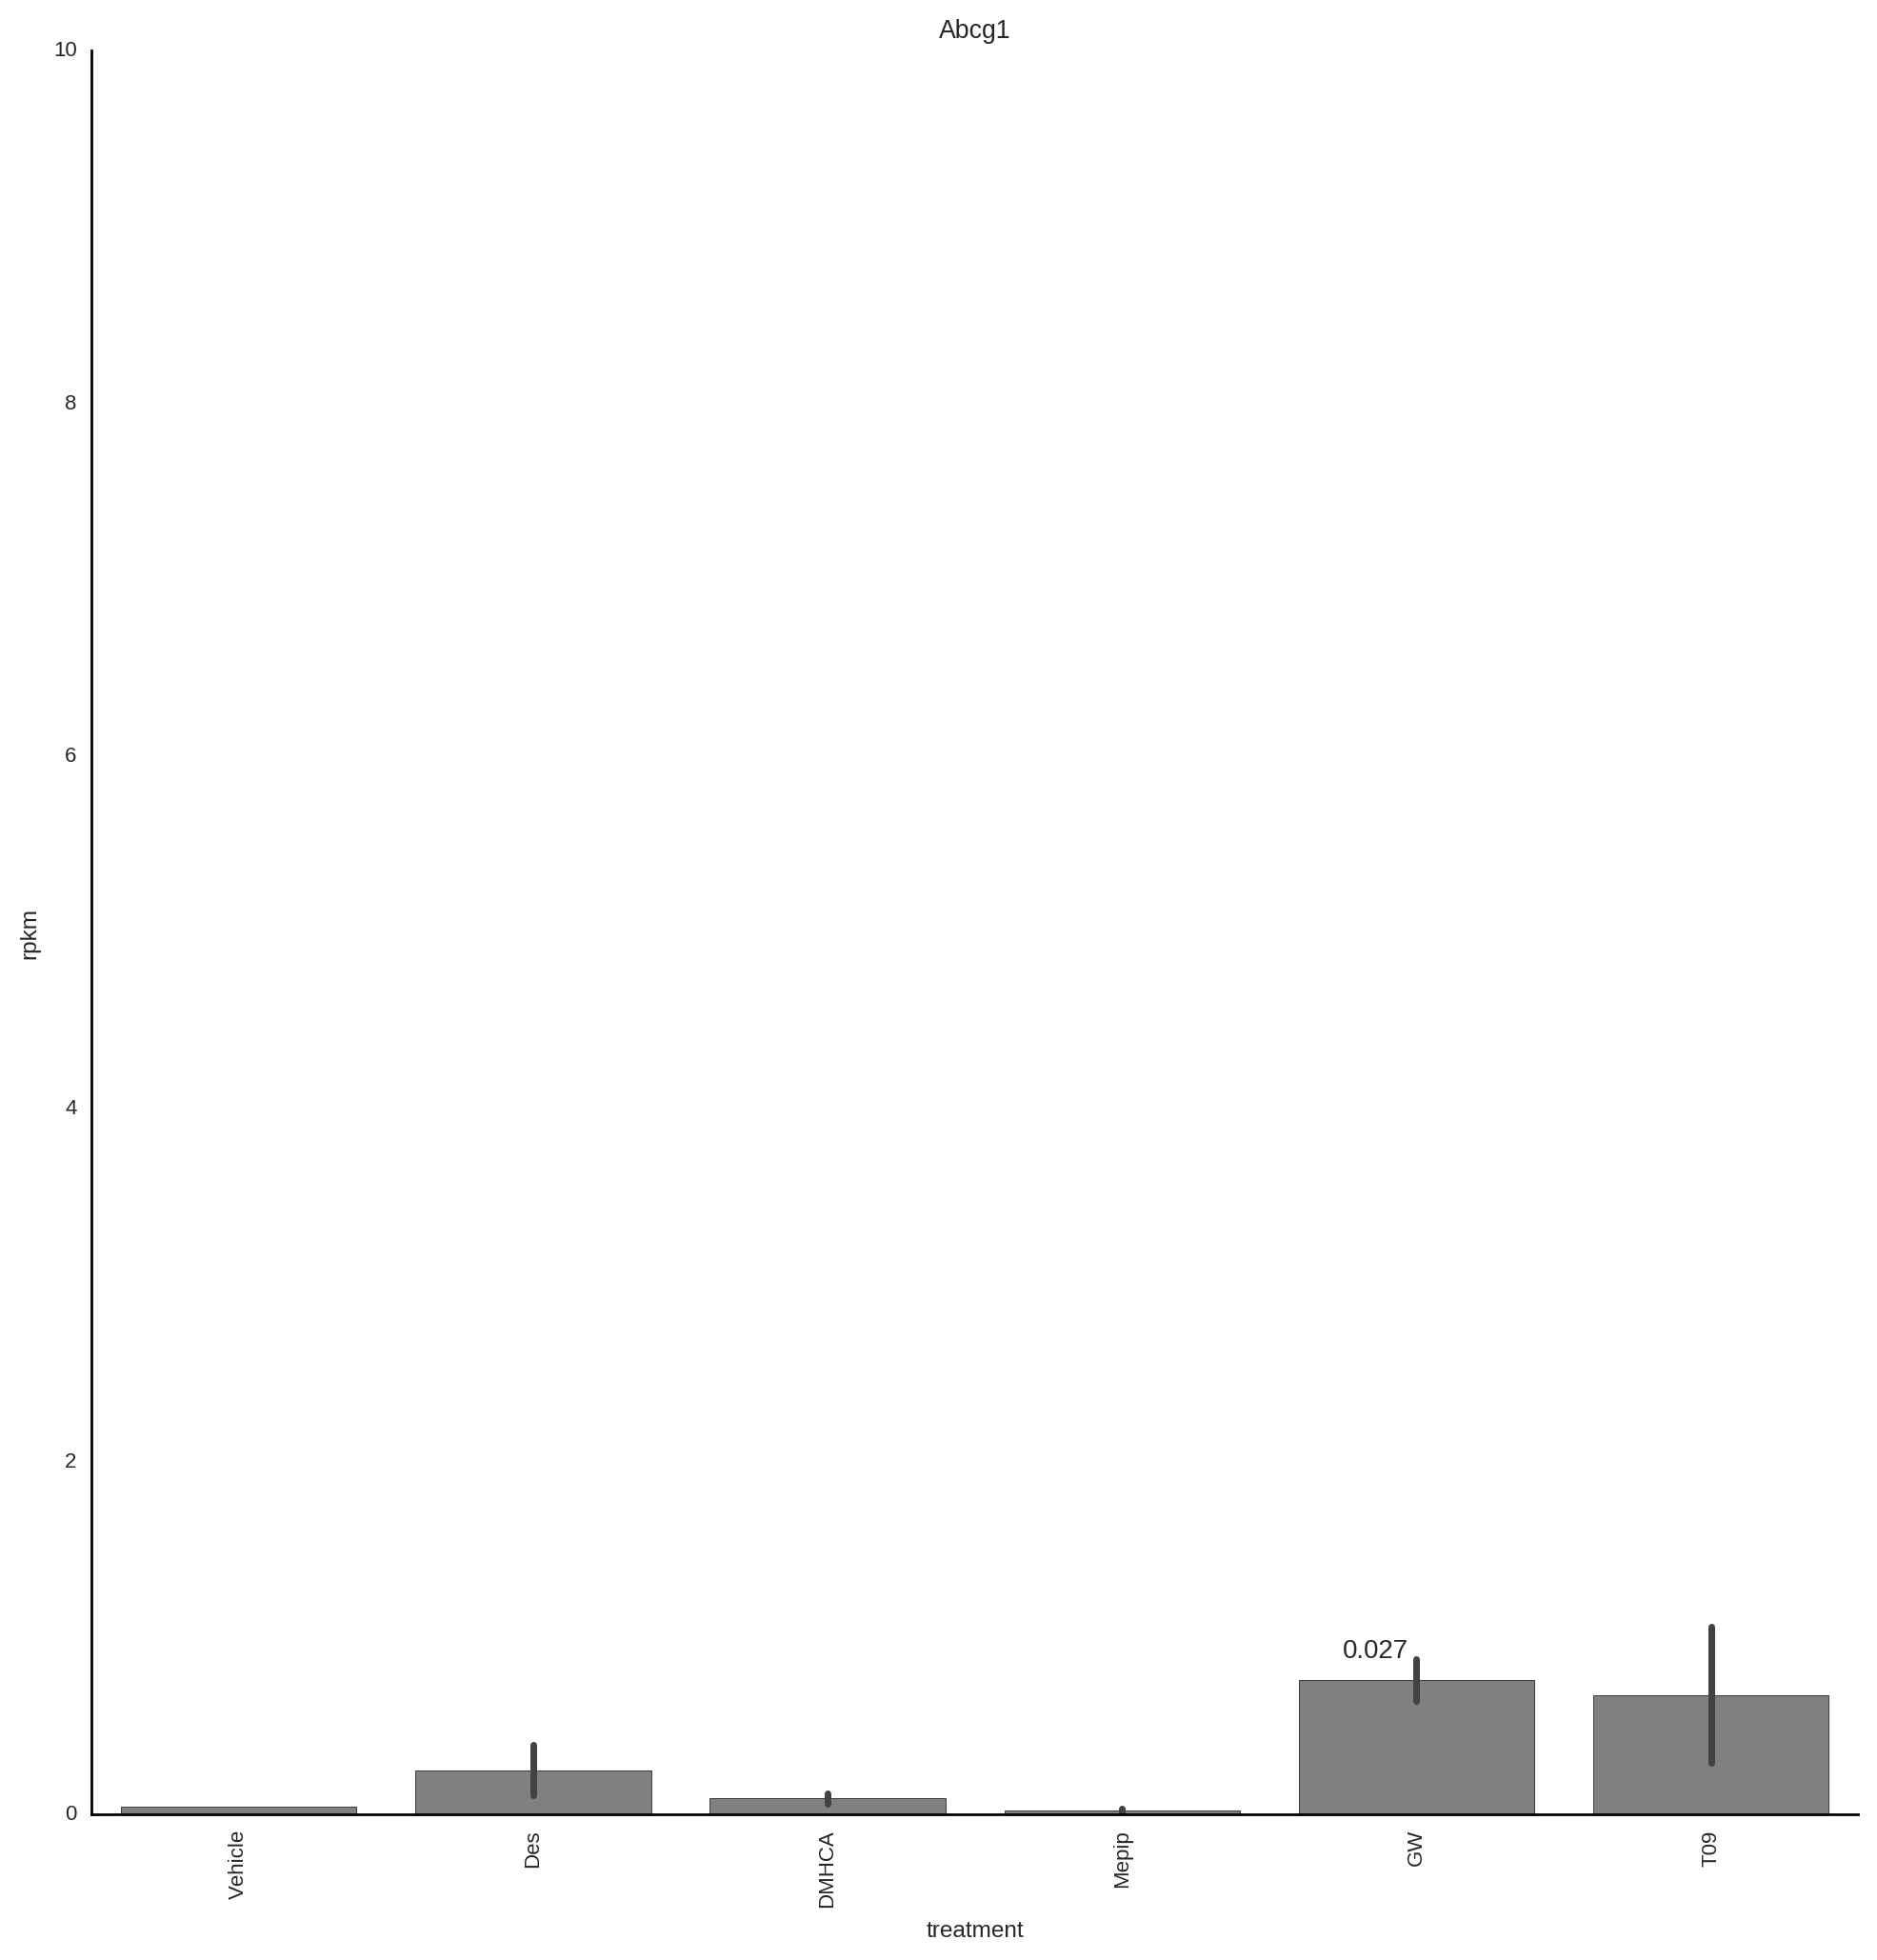

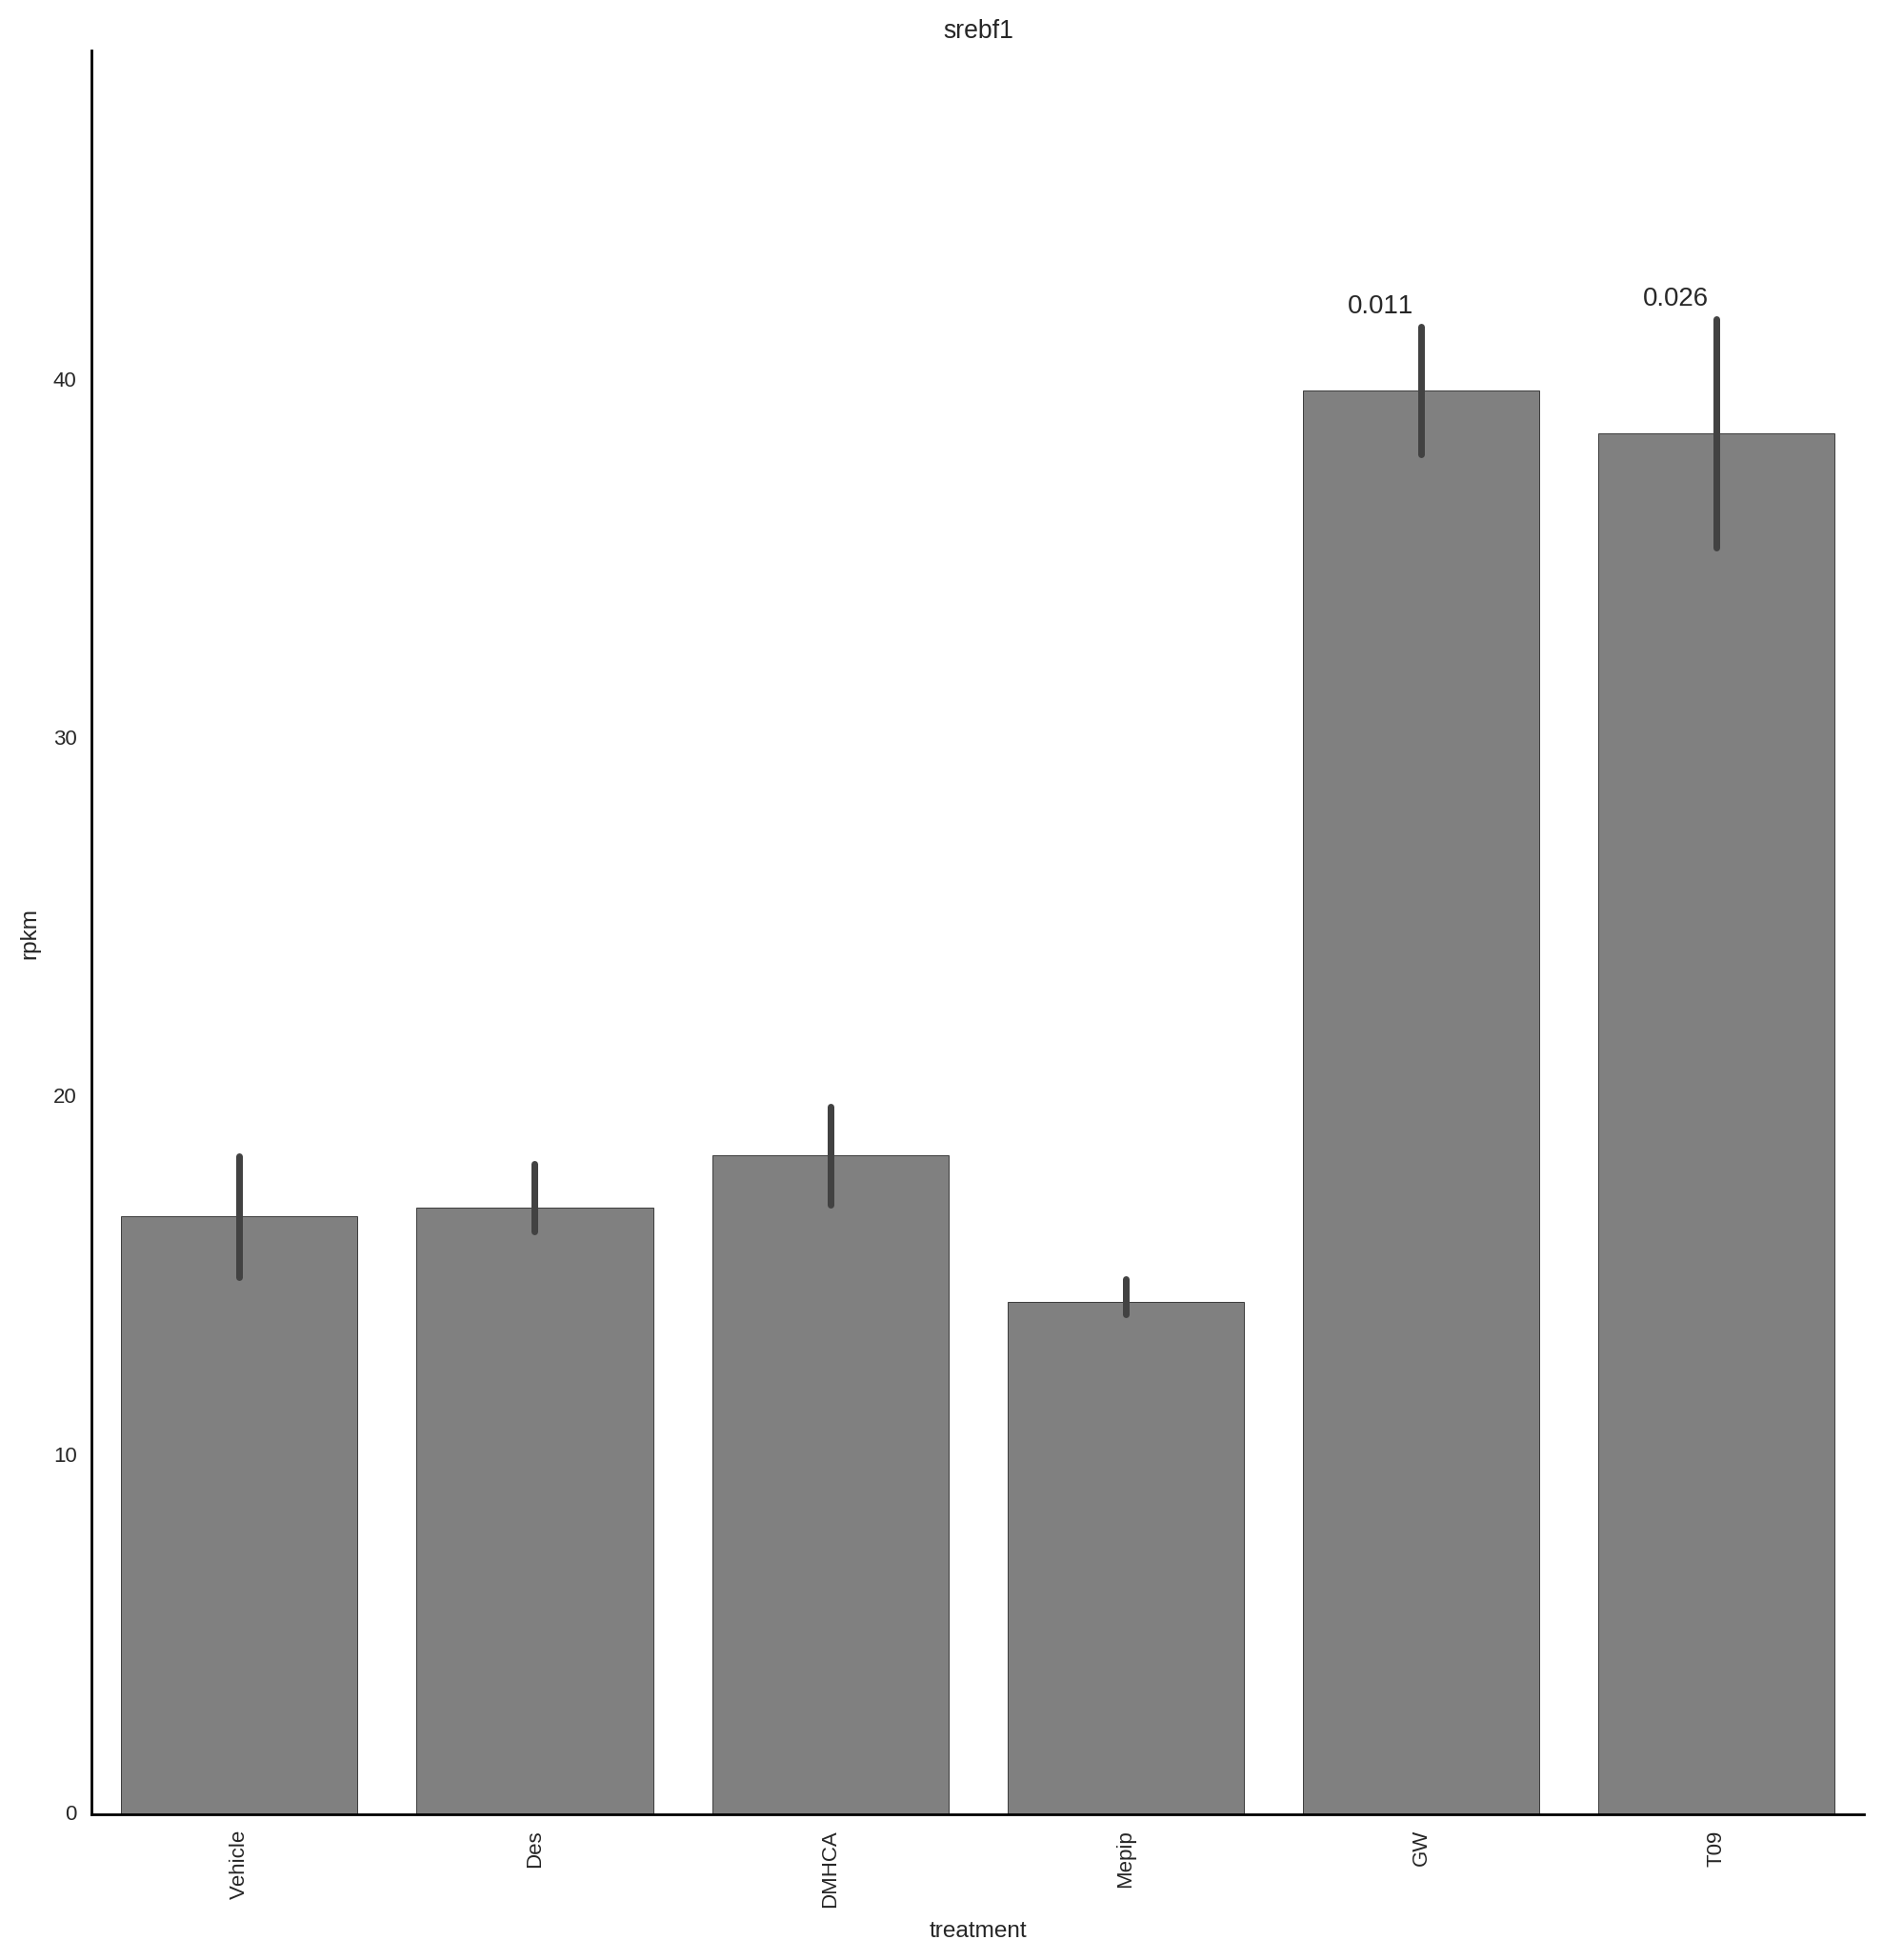

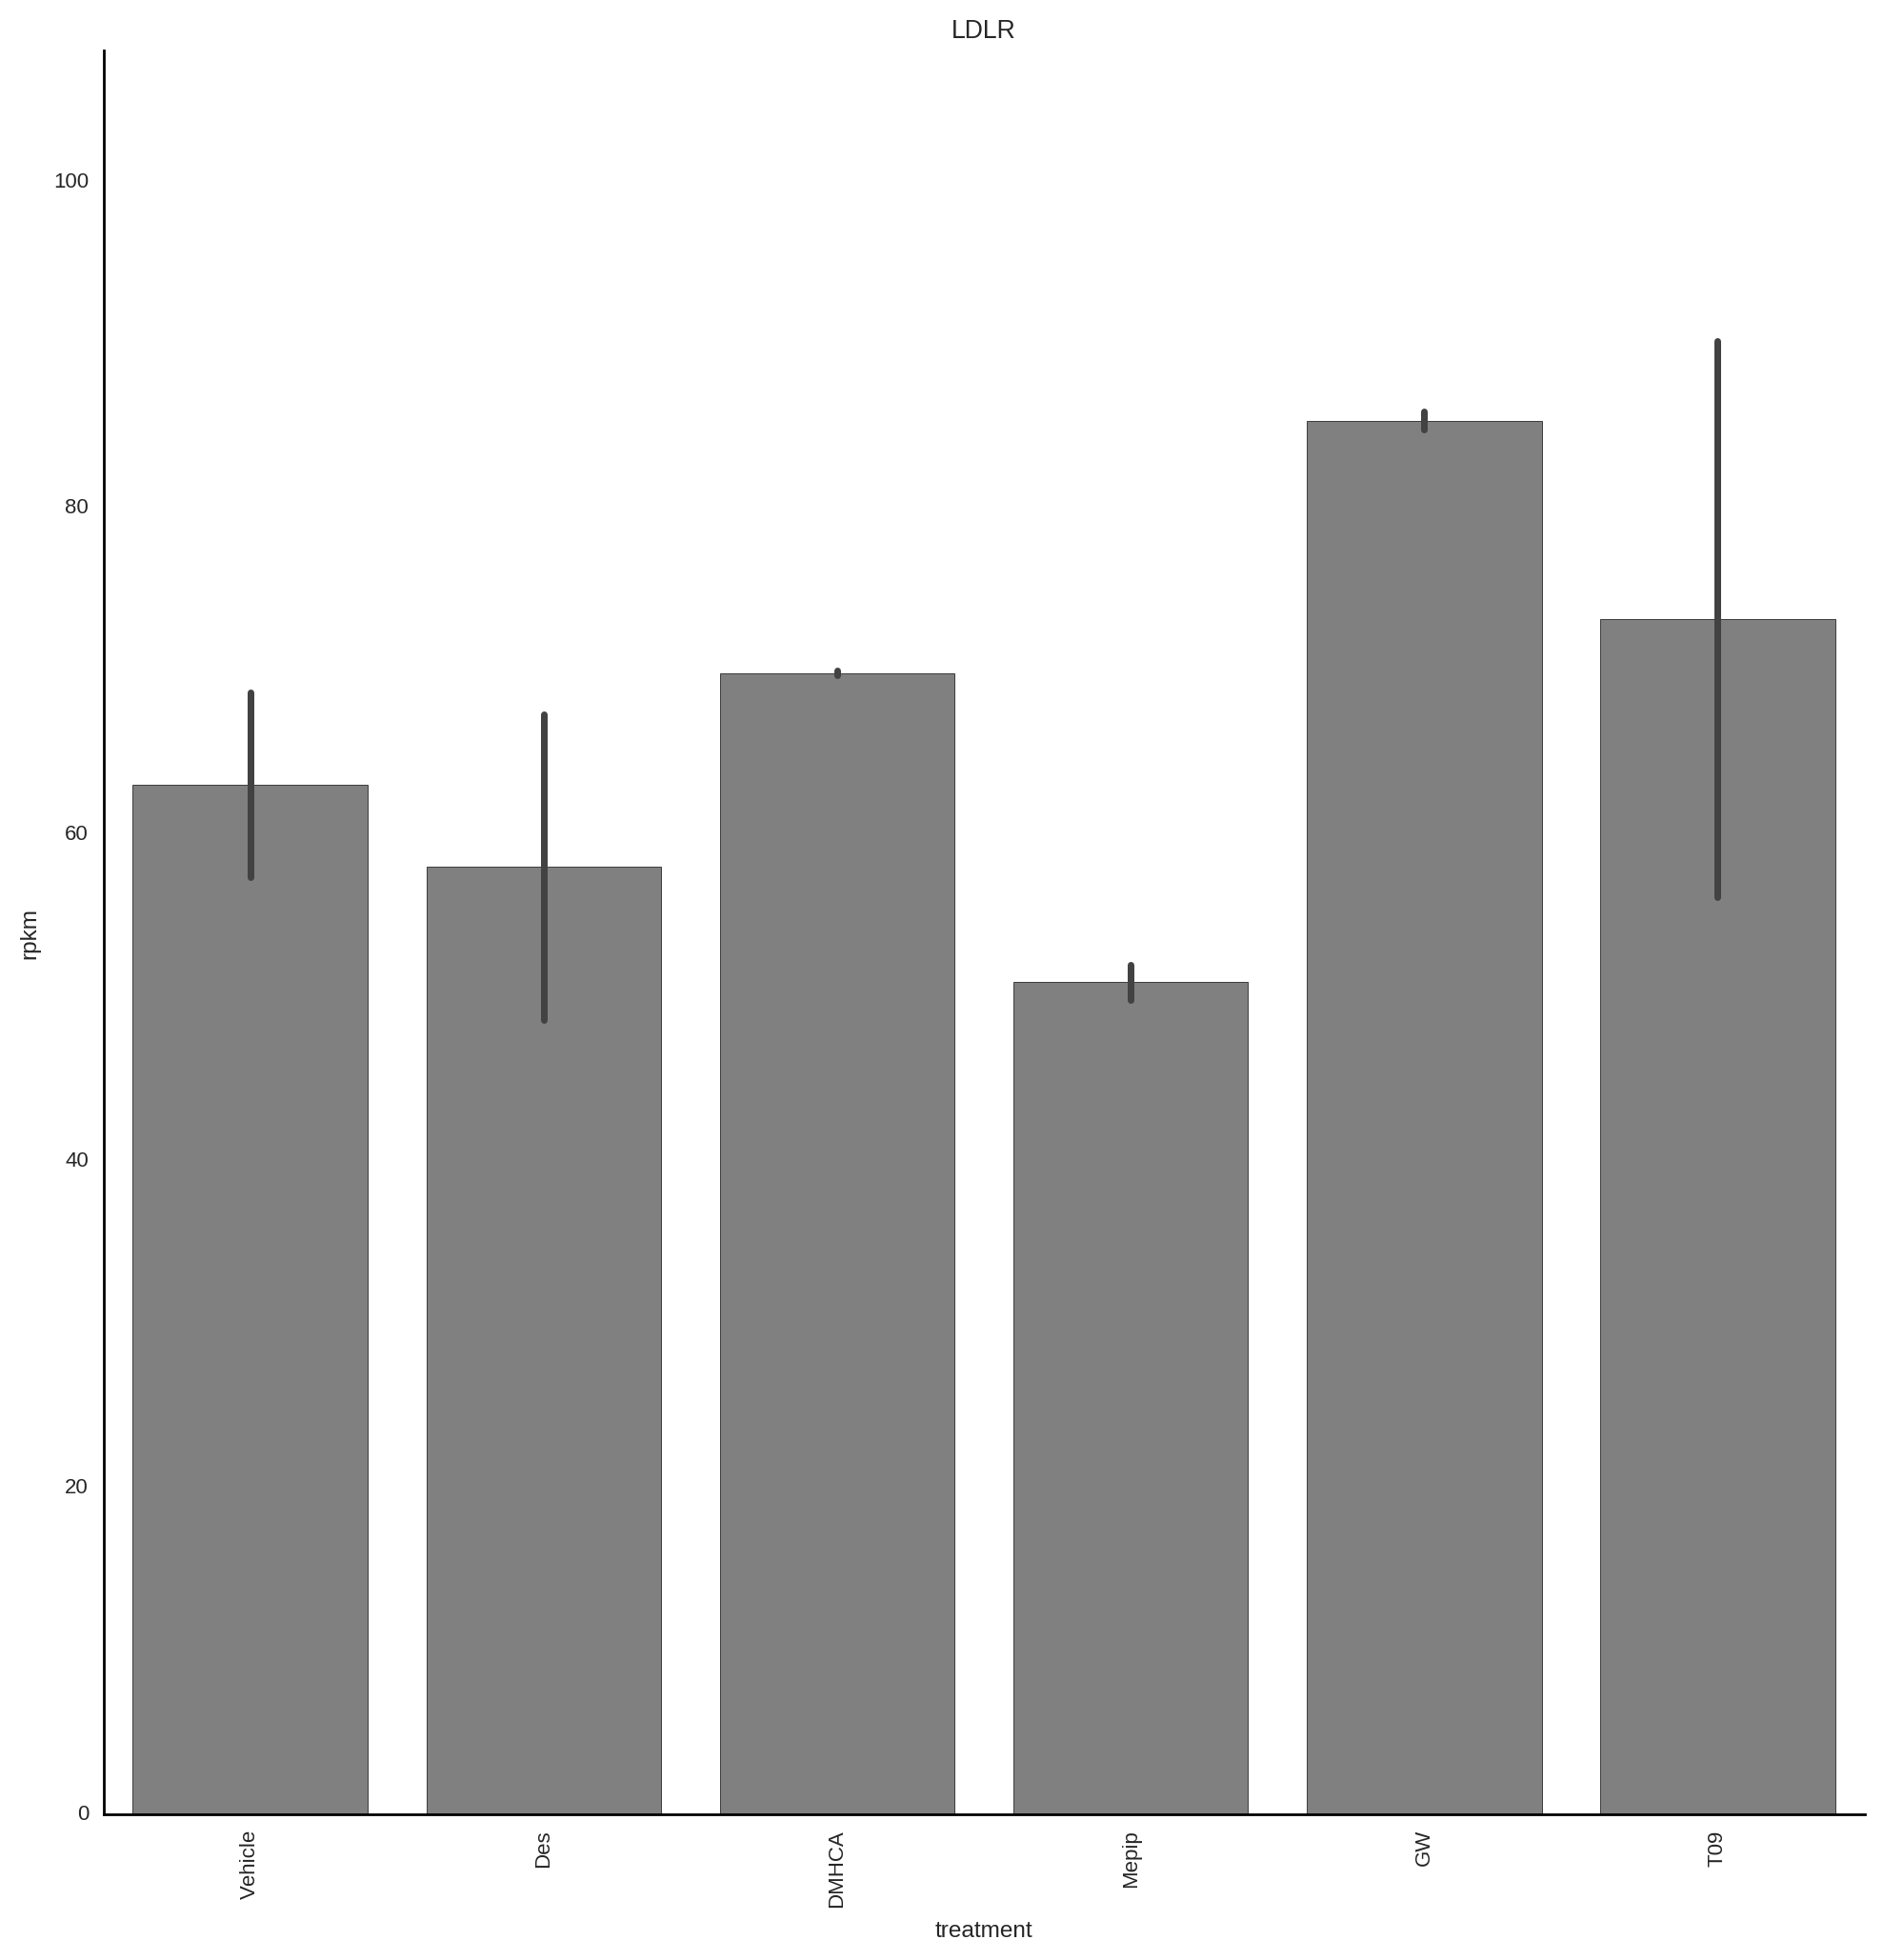

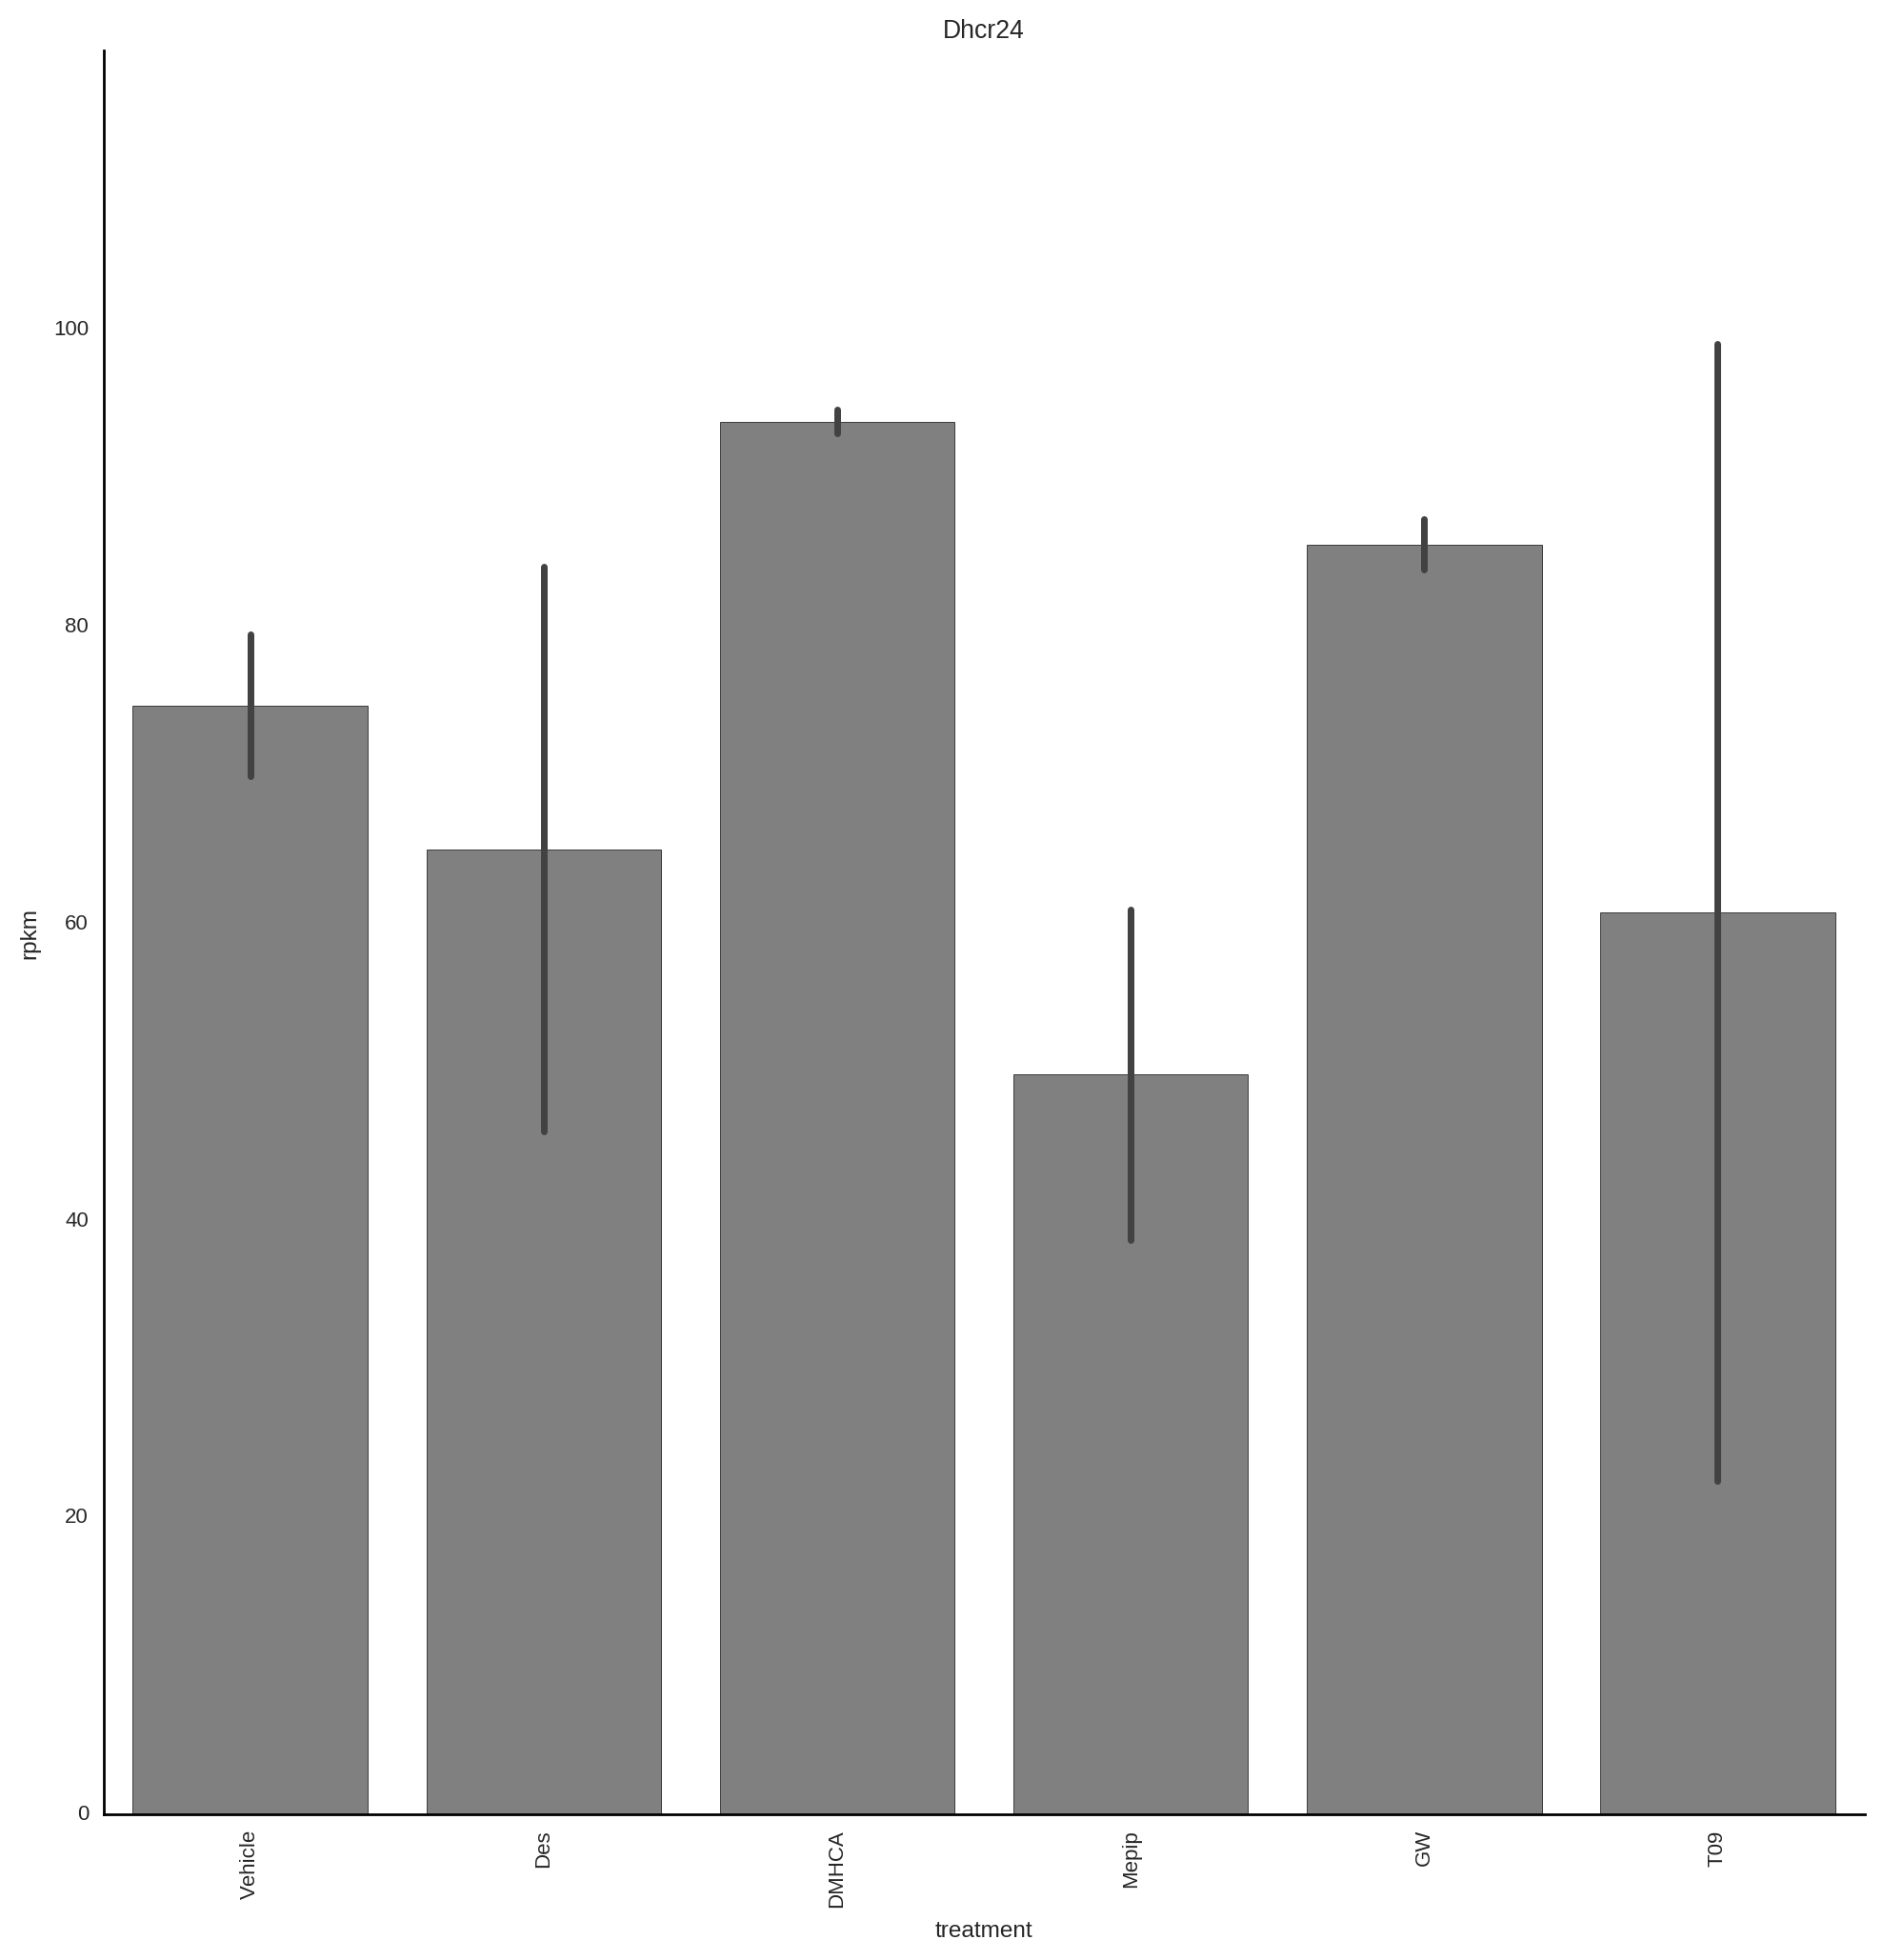

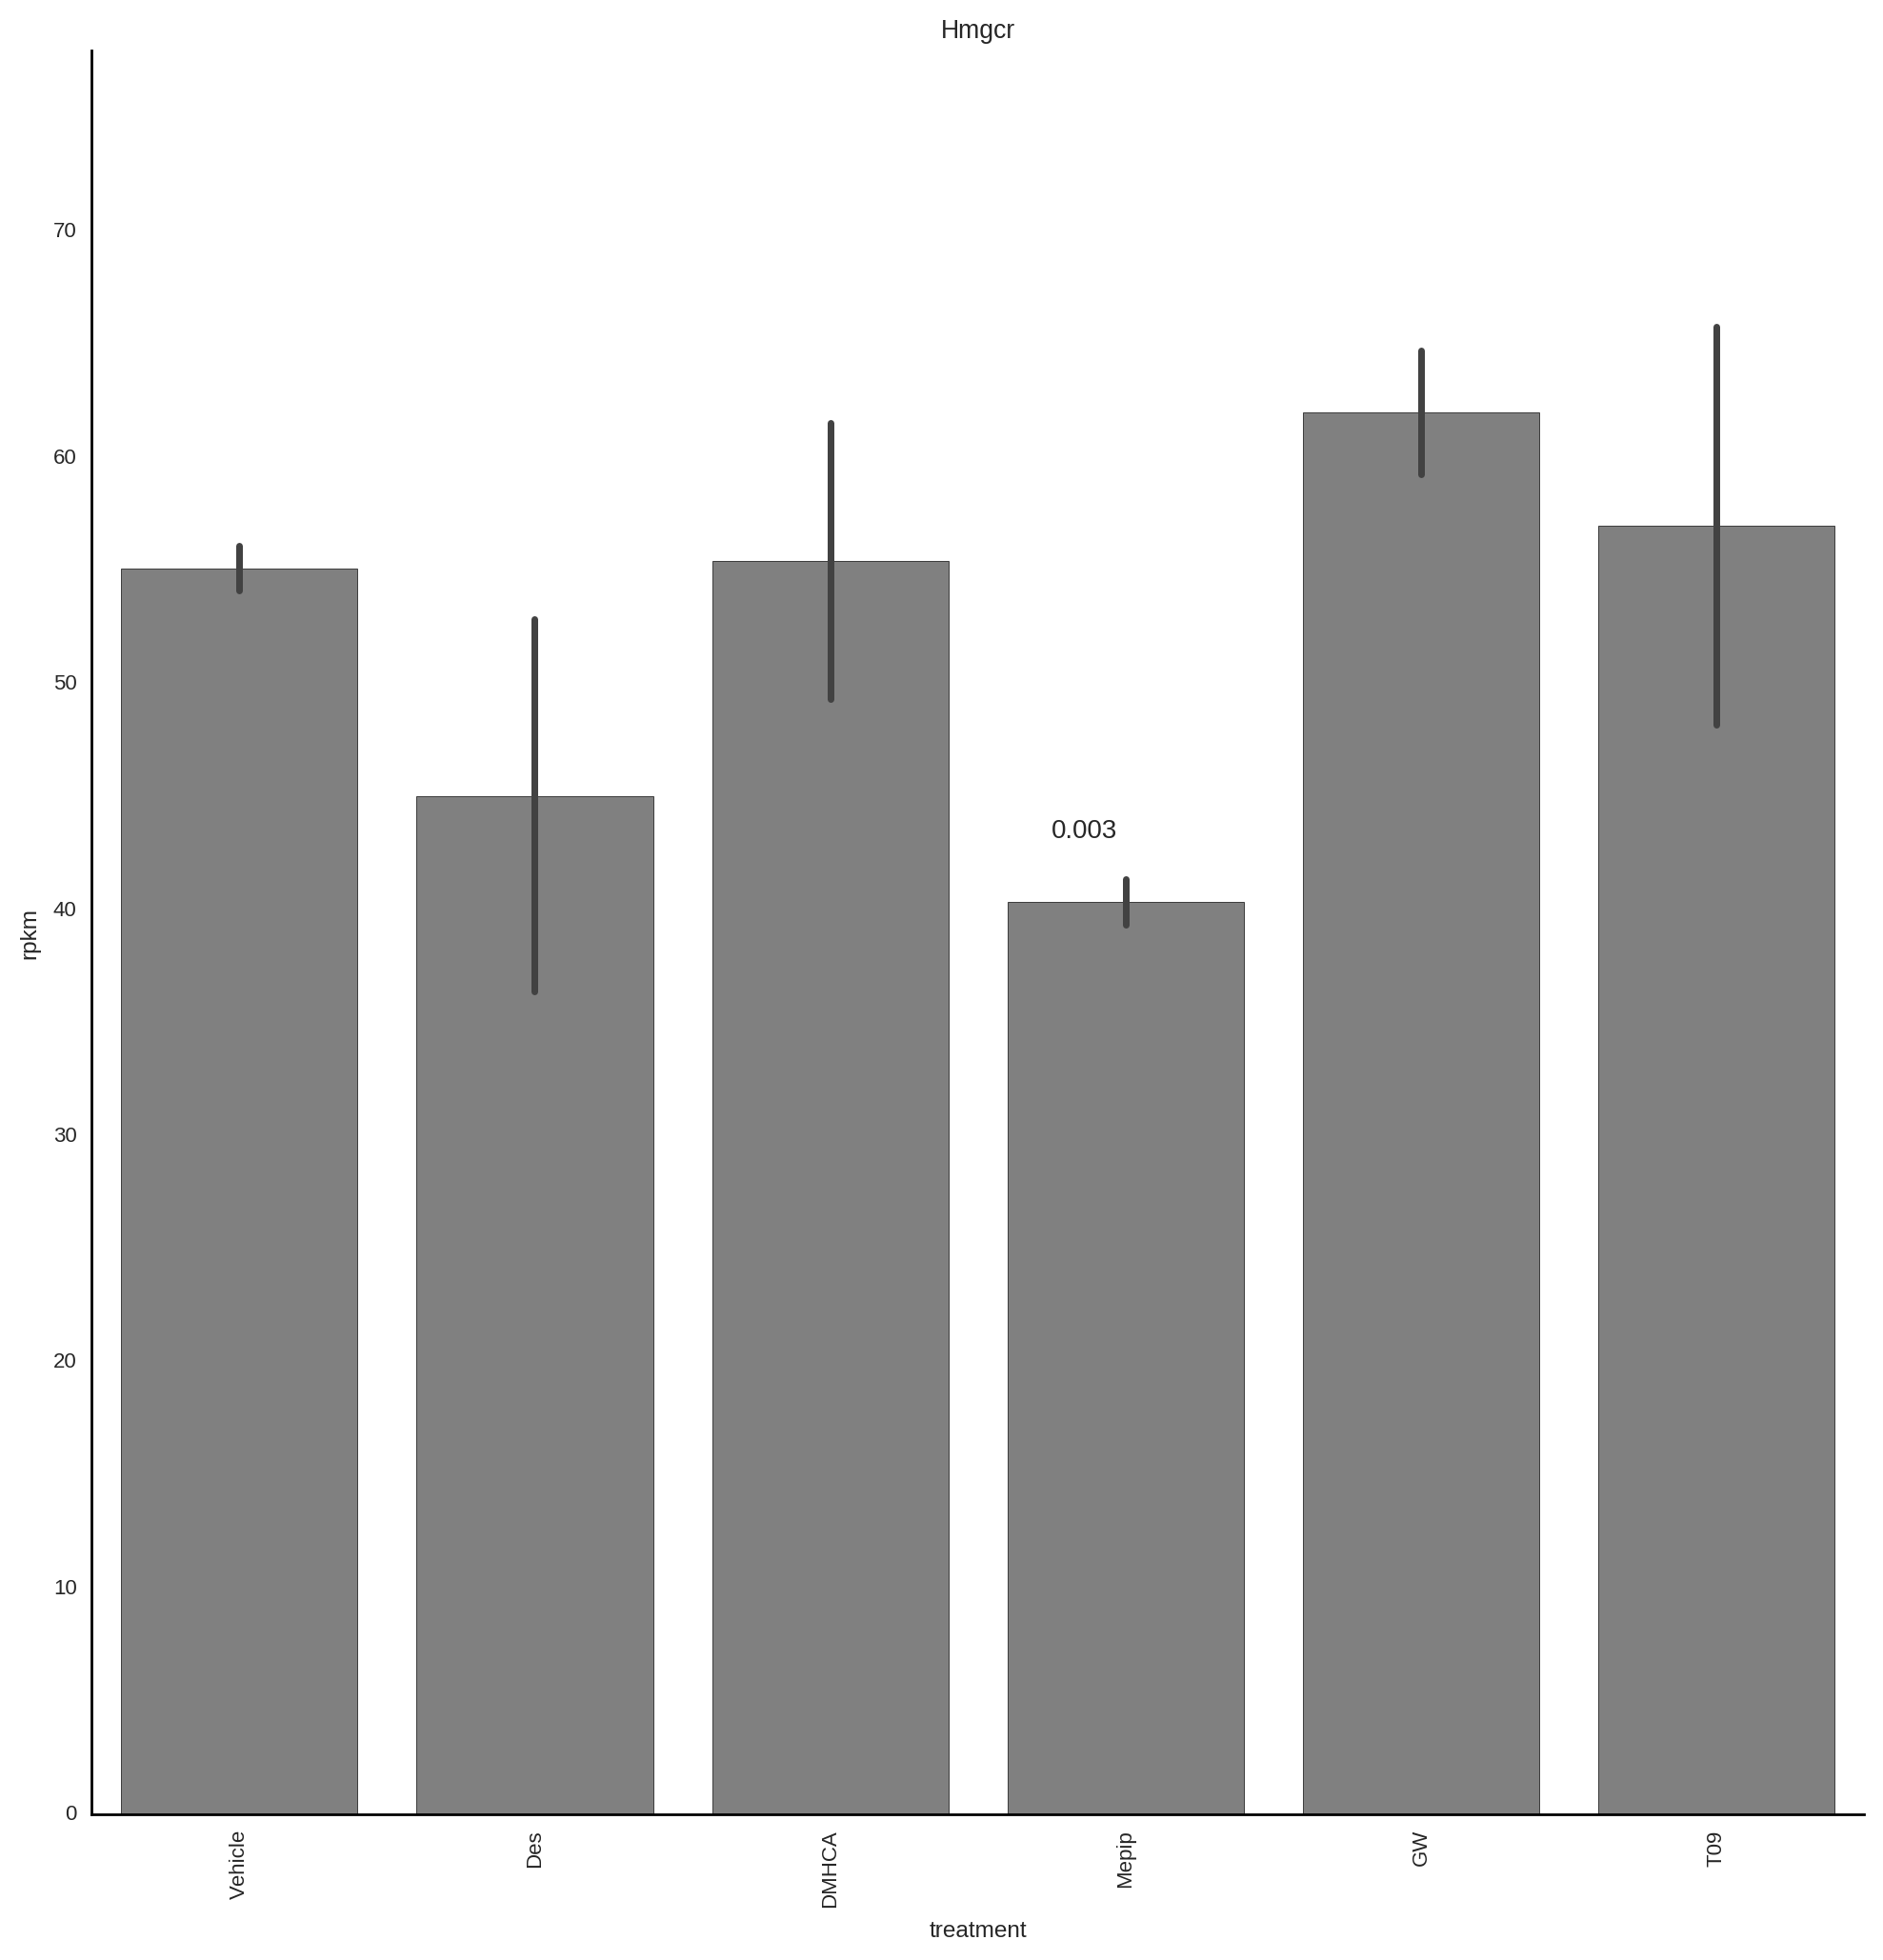

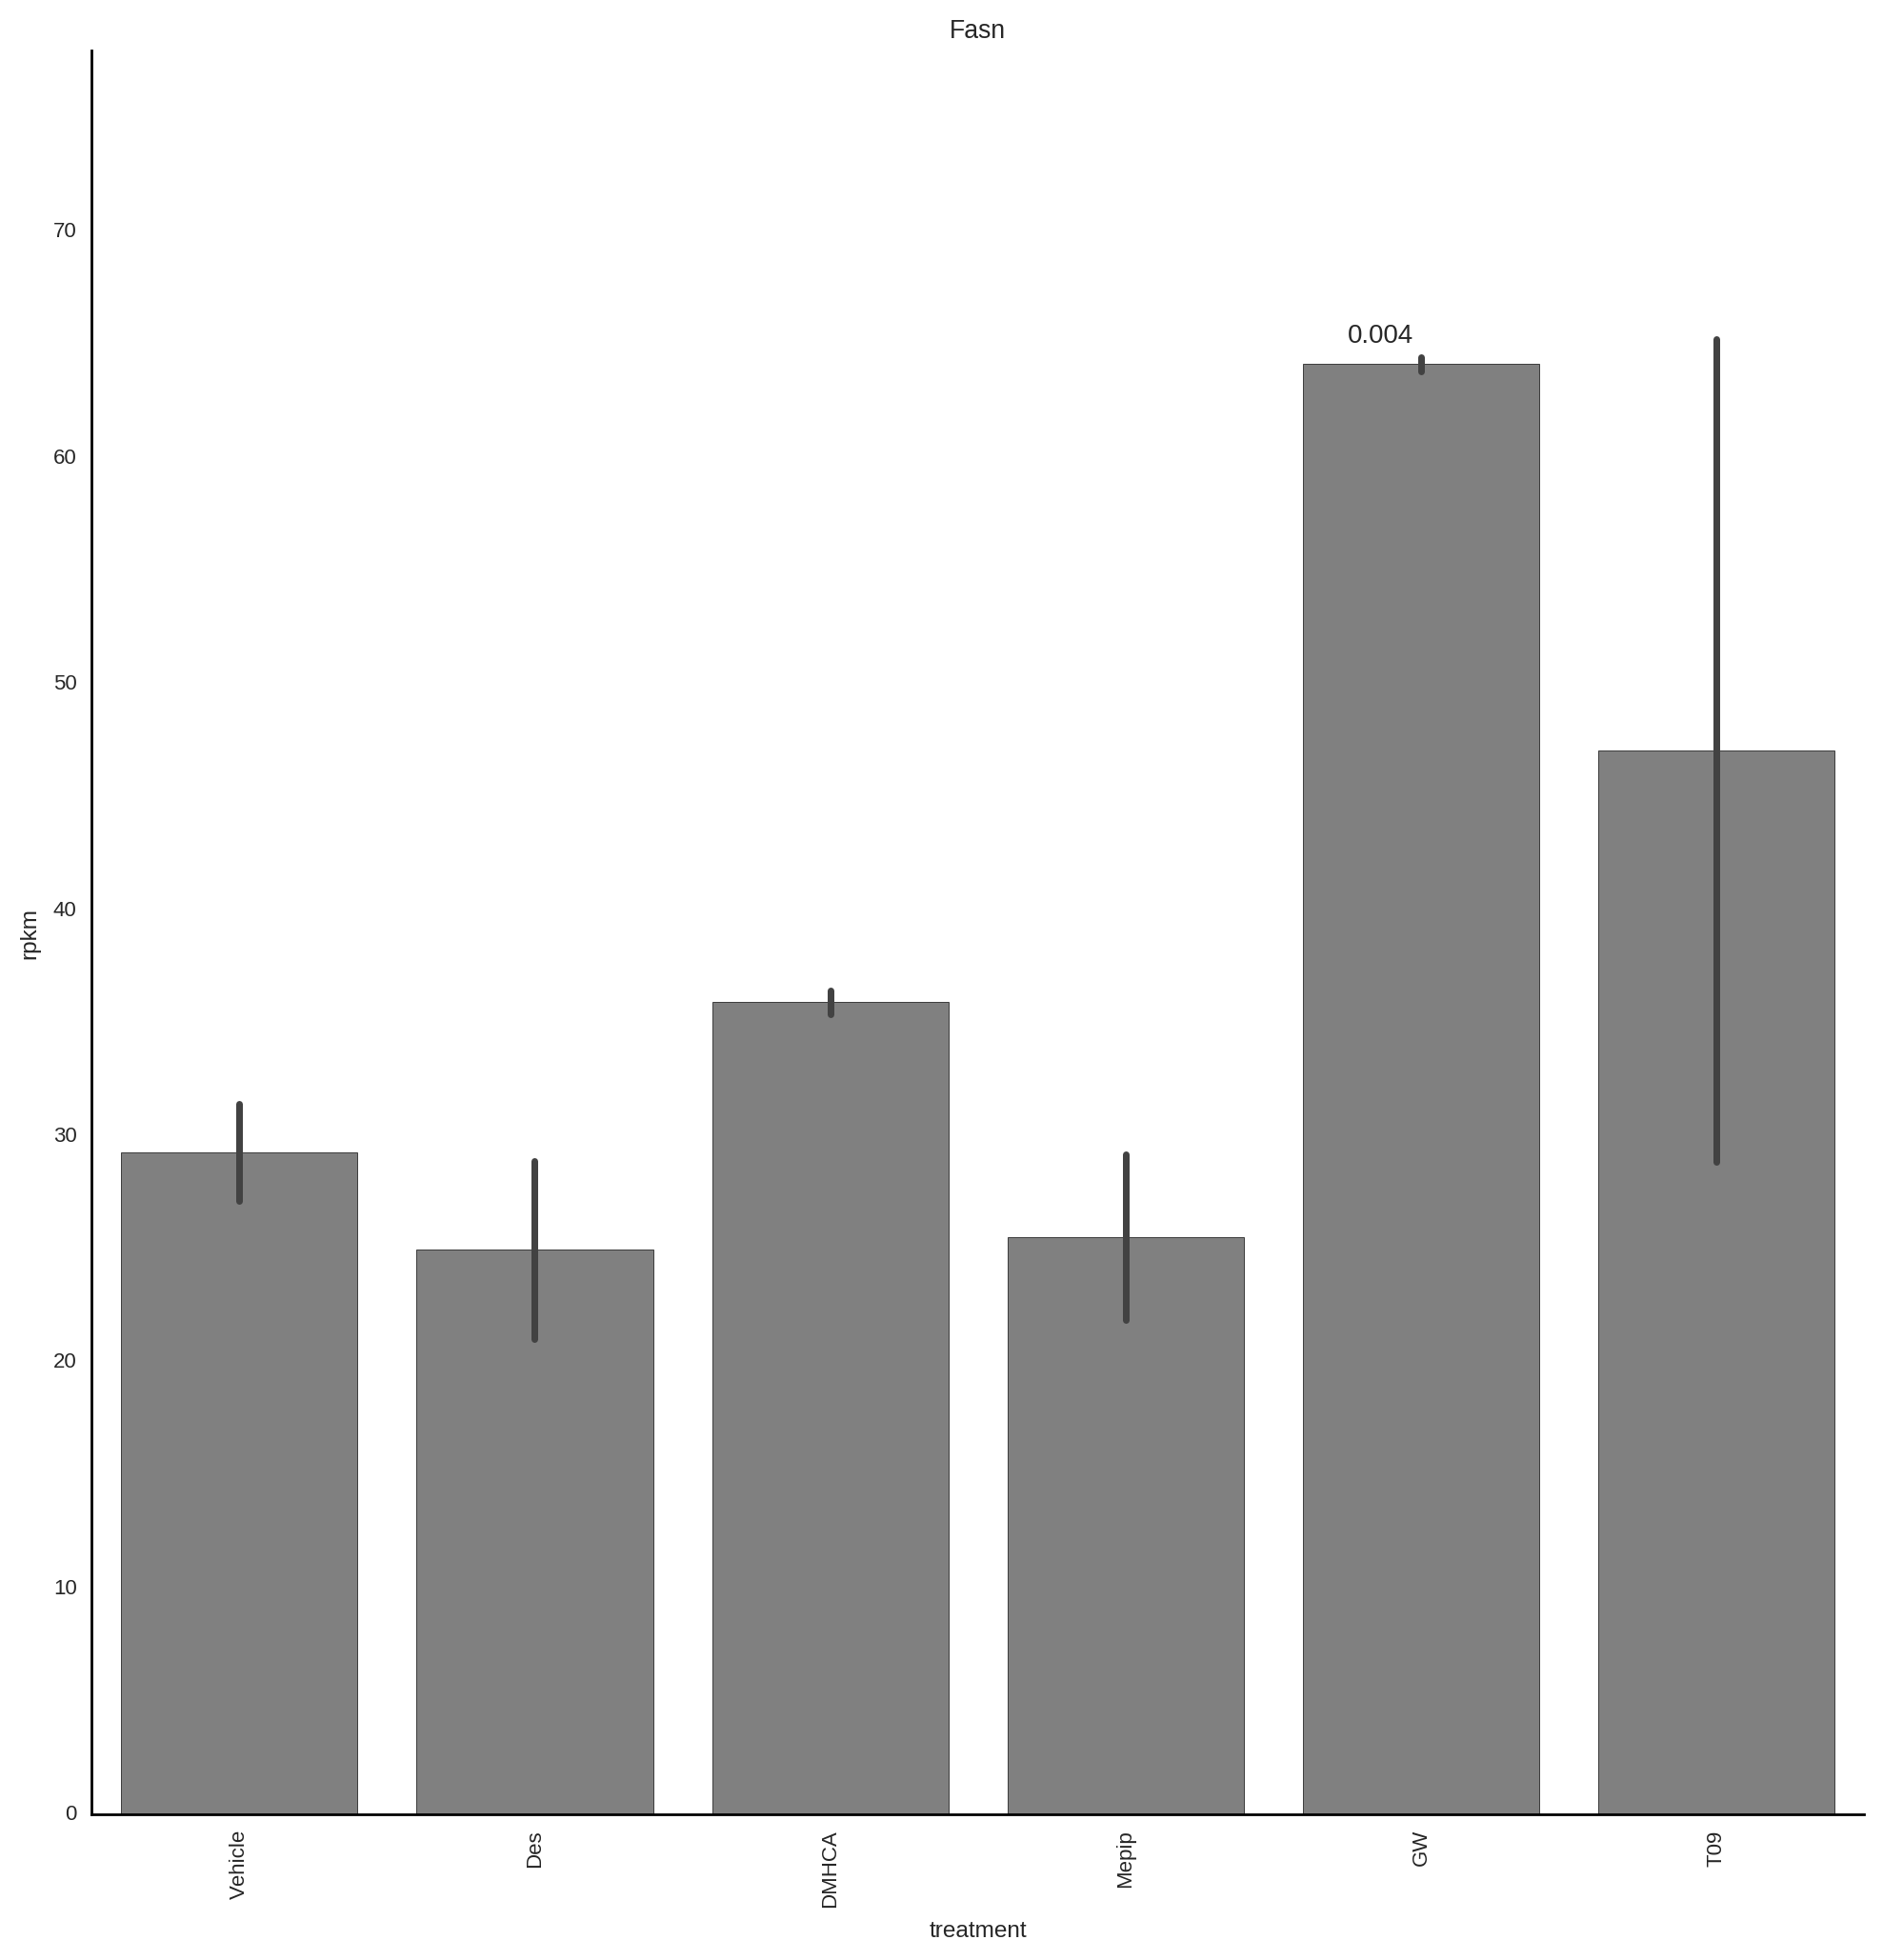

In [395]:
! rm ./bar_plots/*
treatments = ['Vehicle', 
                'Des',
                'DMHCA',
                'Mepip',
                'GW',
                'T09'
                ]
p_threshold = 0.05
sns.set_context('paper')
if not os.path.isdir('bar_plots'):
    os.mkdir('bar_plots')
target_genes = ['Abca1',
'Abcg1',
'srebf1',
'LDLR',
'Dhcr24',
'Hmgcr',
'Fasn'
]
for g in target_genes:
    data = filtered_rpkm_plottingFrame[filtered_rpkm_plottingFrame['gene'] == g.upper()]
    if data.shape[0] > 0:
        sns.factorplot( y='rpkm', 
                        x='treatment',
                        kind='bar',
                        data=data,
                        order = treatments,
                        color='grey',
                        ci=68, size=10
                         )
        plt.xticks(rotation=90)
        # generate p-values vs vehicle
        for i in range(1, len(treatments)):
            treatment_vals = list(data[data['treatment']==treatments[i]]['rpkm'].values)
            vehicle_vals = list(data[data['treatment']== treatments[0]]['rpkm'].values)
            stat, p = scipy.stats.ttest_ind(treatment_vals,
                                           vehicle_vals) 
            ax = plt.gca()
            height = int(np.max(data['rpkm'].values))
            if p < p_threshold:                
                ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),
                            xy=(i - 0.25,max(treatment_vals) + 0.01 *height),
                           fontsize=10)
        if g.upper() in ['DHCR24', 'HMGCR', 'FASN']:
            # generate p values for GW and T vs  desmosterol, dMHCA and PePIP treatments
            stat, p = scipy.stats.ttest_ind(data[
                    data['treatment'].isin(['10um-Des','30um-Des', '1um-DMHCA','1um-Mepip'])]['rpkm'],
                    data[data['treatment'].isin(['1um-GW','1um-T090'])]['rpkm'],
                                           )
            if p < p_threshold: 
                current_height = height + 0.01 * height
                ax.arrow(1, current_height, 0, -0.02*height, linewidth=1.0,head_width=0.0) #left line
                ax.arrow(3, current_height, 0, -0.02*height, linewidth=1.0,head_width=0.0) # right line
                ax.arrow(1, current_height, 2 ,0, linewidth=1.0,head_width=0.0) # horizontal line
                
                ax.arrow(4, current_height, 0, -0.02*height, linewidth=1.0,head_width=0.0) #left line
                ax.arrow(5, current_height, 0, -0.02*height, linewidth=1.0,head_width=0.0) # right line
                ax.arrow(4, current_height, 1 ,0, linewidth=1.0,head_width=0.0) # horizontal line
                
                ax.arrow(2.5, current_height, 0, 0.02*height, linewidth=1.0,head_width=0.0) #left line
                ax.arrow(4.5, current_height, 0, 0.02*height, linewidth=1.0,head_width=0.0) # right line
                ax.arrow(2.5, current_height+0.02*height, 2 ,0, linewidth=1.0,head_width=0.0) # horizontal line
                
                ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),
                            xy=(3.5,current_height+0.03*height), 
                            fontsize=10)


        plt.ylim([0,max([10,height + 0.2*height])])
        plt.title(g)
        plt.savefig('./bar_plots/'+ g +'_rpkm_bar.pdf', bbox_inches='tight')
        plt.show()
        plt.close()




## Tag Scatter Plots

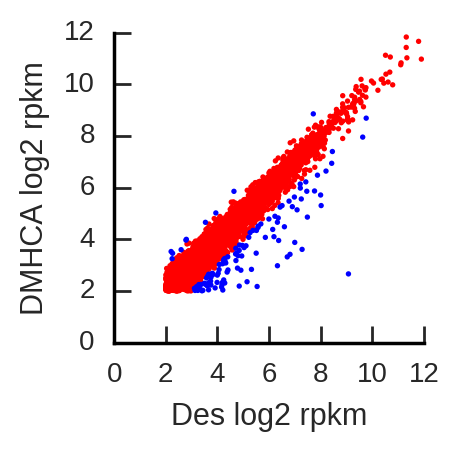

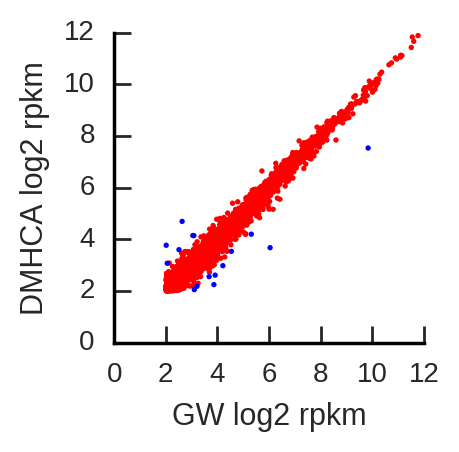

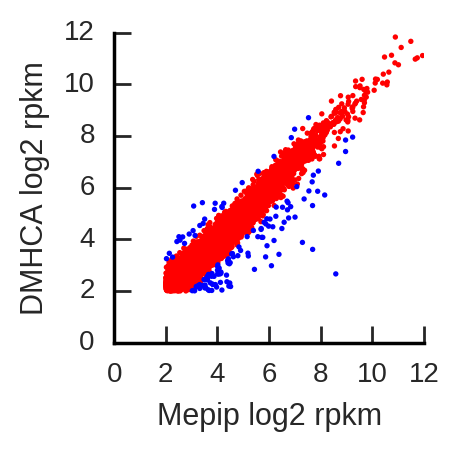

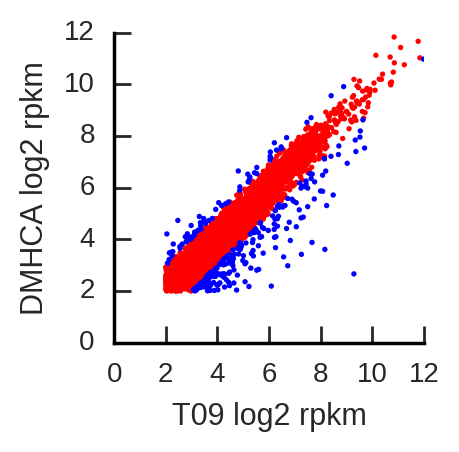

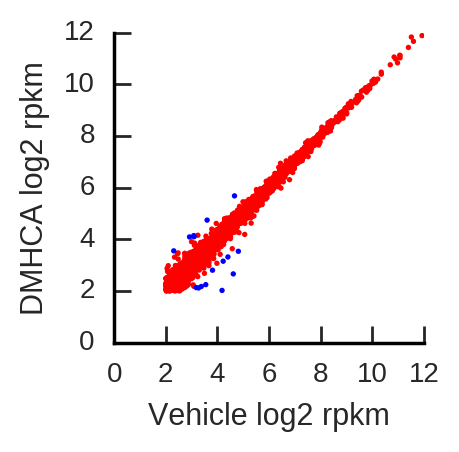

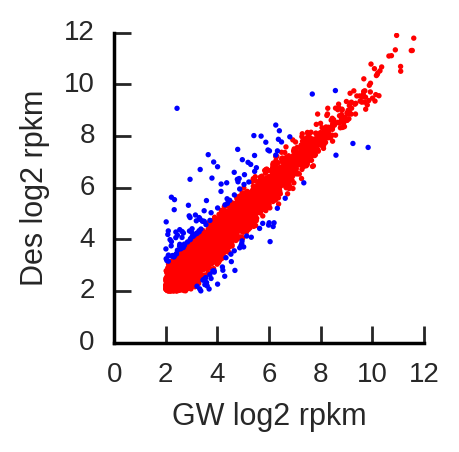

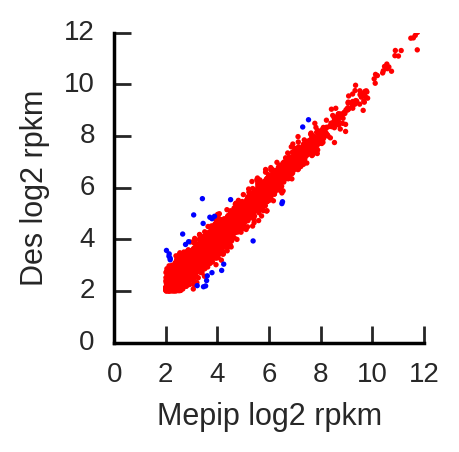

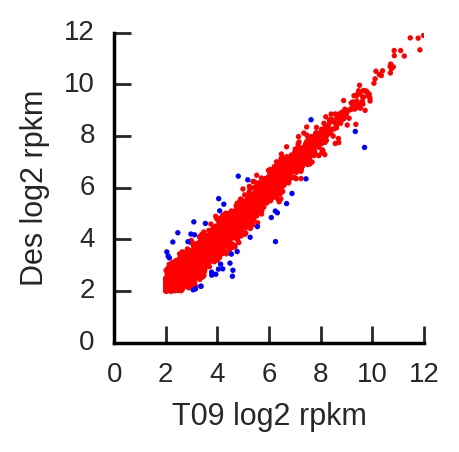

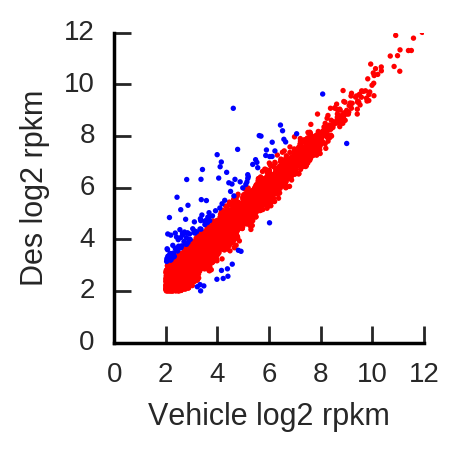

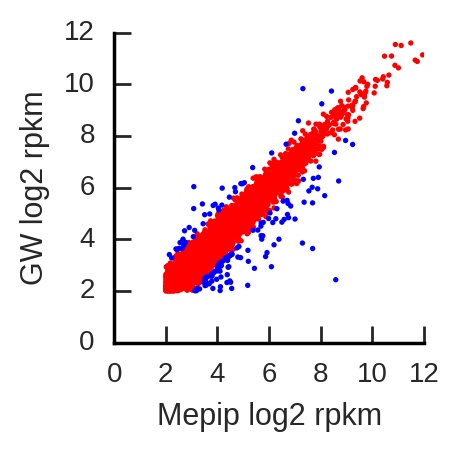

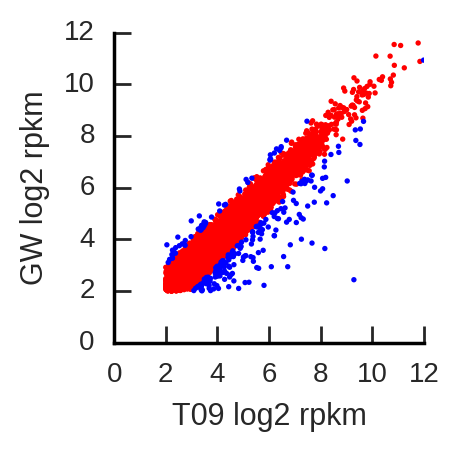

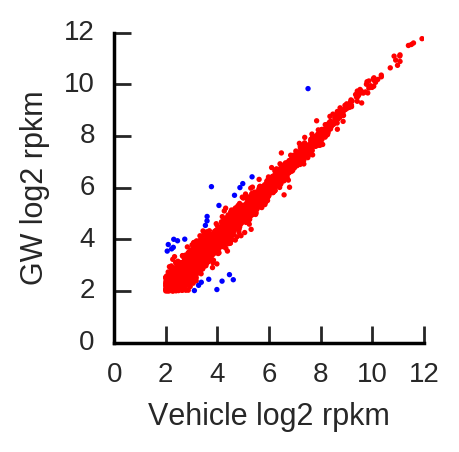

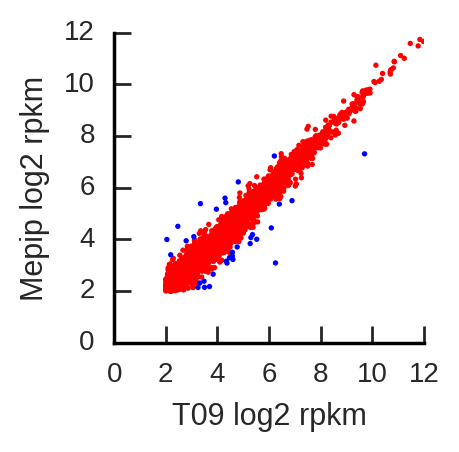

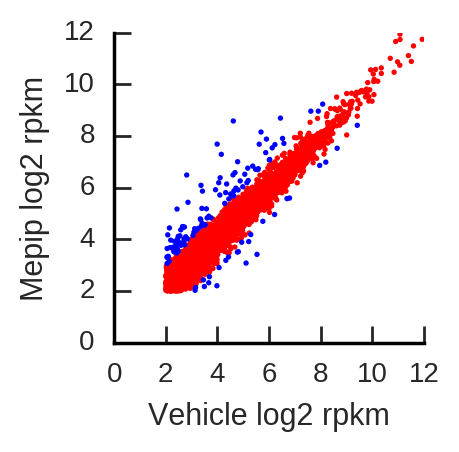

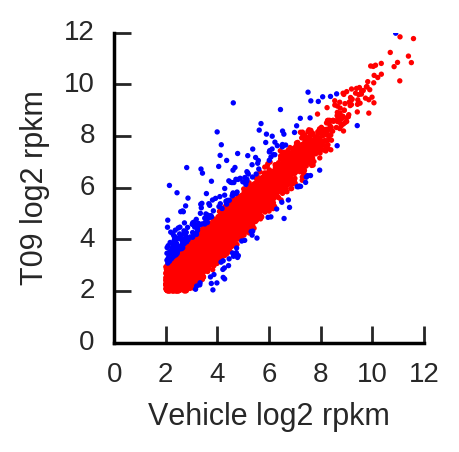

In [36]:
sns.set_style('ticks',{'axes.edgecolor': 'black',
                       'xtick.direction': 'in',
                       'ytick.direction': 'in', 
                         })

! rm ./scatter_plots/*


if not os.path.isdir('./scatter_plots'):
    os.mkdir('./scatter_plots/')
treatment_up_dict = {}
treatment_down_dict = {}
   
fdr_threshold = 0.05
fold_threshold = 2
rpkm_cutoff = 4.0
   
fdrColumns = [x for x in diffExpression_frame.columns if 'FDR' in x]


for c in fdrColumns:
        tokens = c.split()
        if 'veh' in tokens[0].lower():
            treatment1 = tokens[0]
            treatment2 = tokens[2]
        else:
            treatment1 = tokens[2]
            treatment2 = tokens[0]
        if True:
            
            fc_column = c.replace('FDR', 'logFC')

            diff_genes = diffExpression_frame[diffExpression_frame[c] < fdr_threshold]['gene'].values

            columns1 = filtered_summary_frame[filtered_summary_frame['simpleTreatment'] == treatment1]['simplifiedName']
            columns2 = filtered_summary_frame[filtered_summary_frame['simpleTreatment'] == treatment2]['simplifiedName']

            reads1 = idr_rpkm_frame.loc[:,columns1].mean(axis=1)
            reads2 = idr_rpkm_frame.loc[:,columns2].mean(axis=1)

            all_genes = idr_rpkm_frame.index.values
            read_tuple_list = tuple(zip(all_genes, reads1, reads2))
            filtered_read_tuple_list = [x for x in read_tuple_list if x[1] >= rpkm_cutoff and x[2]>= rpkm_cutoff ]
            
            filtered_genes = [x[0] for x in filtered_read_tuple_list]
            reads1 = np.array([x[1] for x in filtered_read_tuple_list])
            reads2 = np.array([x[2] for x in filtered_read_tuple_list])
            
            fold_genes = []
            for i in range(len(filtered_genes)): 
                fold = (reads1[i]+0.01)/(reads2[i]+0.01)
                if fold >=fold_threshold or fold <=1/fold_threshold:
                    fold_genes.append(filtered_genes[i])
            
#             colors = ['blue' if x in diff_genes and x in fold_genes else 'grey' if x in fold_genes else 'lightgrey' for x in idr_rpkm_frame.index.values]
#             colors = ['blue' if x in diff_genes or x in fold_genes else 'red' for x in filtered_genes]
            colors = ['blue' if x in fold_genes else 'red' for x in filtered_genes]


            # log values
            reads1 = np.log2(reads1 + 0.0000001)
            reads2 = np.log2(reads2 + 0.0000001)

            # ensure diff diff expressed genes are on top
            val_tuples = tuple(zip(reads1,reads2,colors))
            sorted_tuples = sorted(val_tuples,key=lambda x: x[2], reverse=True)
            reads1 = [x[0] for x in sorted_tuples] 
            reads2 = [x[1] for x in sorted_tuples]
            colors = [x[2] for x in sorted_tuples]
            plt.figure(figsize=(2,2))
            plt.scatter(reads1, reads2, edgecolors='none', c=colors, marker = '.', s=15)
            sns.despine()
            # fix aspect ratio
            ax = plt.gca()
            ax.set_xlim((0,12))
            ax.set_ylim((0,12))
            x0,x1 = ax.get_xlim()
            y0,y1 = ax.get_ylim()
            ax.set_aspect(abs(x1-x0)/abs(y1-y0))        
            plt.xlabel(treatment1 + ' log2 rpkm')
            plt.ylabel(treatment2 + ' log2 rpkm')
#             plt.legend(recs,classes,loc=4)
            plt.savefig('./scatter_plots/'+ treatment1 + '_' + treatment2 + '_logRPKM_scatter.png', bbox_inches='tight')
            plt.savefig('./scatter_plots/'+ treatment1 + '_' + treatment2 + '_logRPKM_scatter.pdf', bbox_inches='tight')
            plt.show()
            
        

## PCA Analysis

num down 18 num up 29


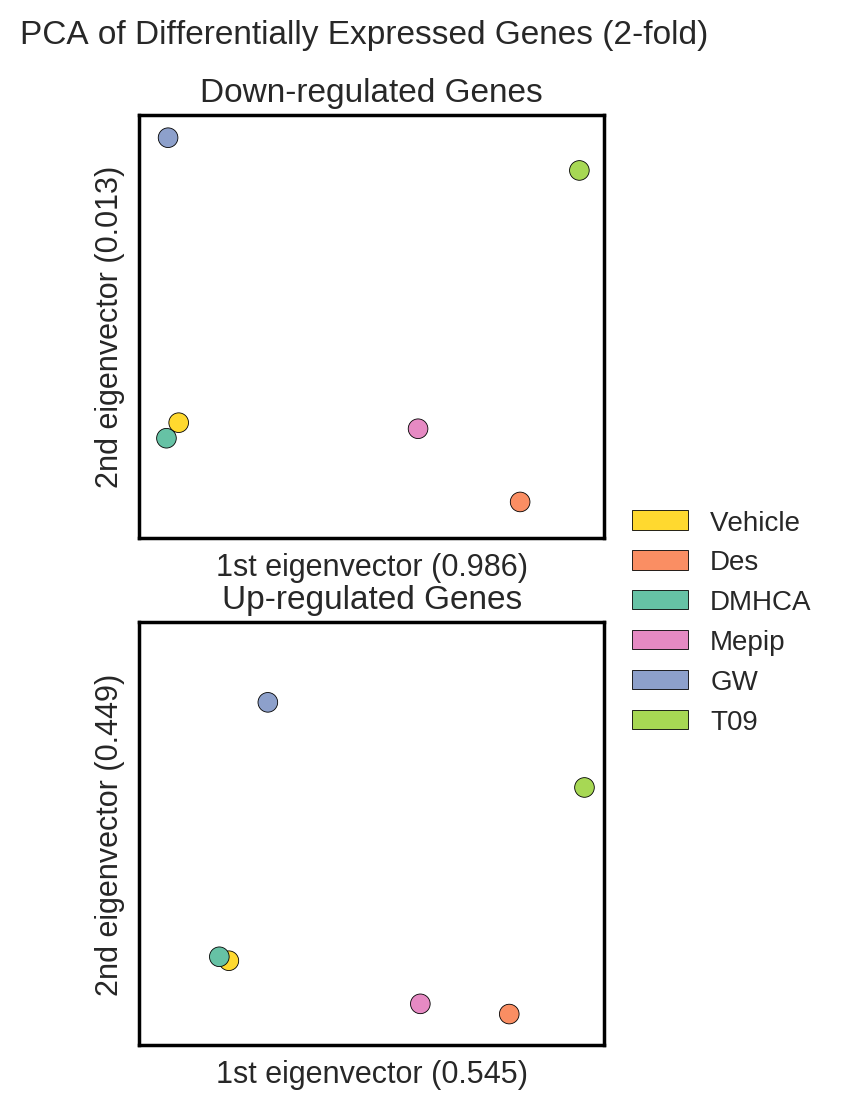

In [69]:
### for up-regulated genes
from matplotlib import patches as mpatches

colorDict = dict(zip(sorted(set(filtered_summary_frame['simpleTreatment'].values)), 
                 sns.color_palette("Set2") + sns.color_palette("colorblind")))

fdr_threshold = 0.05
fold_threshold = np.log2(2)
fdr_cols = [x for x in diffExpression_frame.columns if 'FDR' in x and 'vs. Vehicle' in x]
fold_cols = [x for x in diffExpression_frame.columns if 'logFC' in x and 'vs. Vehicle' in x]

down_diff_genes = diffExpression_frame[(diffExpression_frame[fdr_cols].min(axis=1) < fdr_threshold) &
                                  (diffExpression_frame[fold_cols].max(axis=1) >= fold_threshold)
                                 ]['gene'].values
down_diff_genes = [x.upper() for x in down_diff_genes]

up_diff_genes = diffExpression_frame[(diffExpression_frame[fdr_cols].min(axis=1) < fdr_threshold) &
                                  (diffExpression_frame[fold_cols].min(axis=1) <= -1*fold_threshold)
                                 ]['gene'].values
up_diff_genes = [x.upper() for x in up_diff_genes]

print('num down', len(down_diff_genes), 'num up', len(up_diff_genes))
f, axs = plt.subplots(2,1, figsize=(3,6))
plt.suptitle('PCA of Differentially Expressed Genes (2-fold)')

### down_regulated genes
features = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(down_diff_genes)]
colors = [colorDict[x] for x in features.columns.values]

down_model = sklearn.decomposition.PCA(n_components=2)
reduced_features = down_model.fit_transform(features.T)
explained_variance_ratios = down_model.explained_variance_ratio_

plt.subplot(2,1,1)  
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, s=50)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])
plt.title('Down-regulated Genes')

### up-regulatd genes
features = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(up_diff_genes)]
colors = [colorDict[x] for x in features.columns.values]

up_model = sklearn.decomposition.PCA(n_components=2)
reduced_features = up_model.fit_transform(features.T)
explained_variance_ratios = up_model.explained_variance_ratio_

plt.subplot(2,1,2)  
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, s=50)
plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])
plt.title('Up-regulated Genes')

# legend
classes = ['Vehicle', 'Des', 'DMHCA', 'Mepip','GW', 'T09']

classes = [x for x in classes if not '30' in x]
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc='right', bbox_to_anchor=(1.5, 1.0))

plt.savefig('pca_2fold.pdf',bbox_inches='tight')
plt.show()

num down 31 num up 46


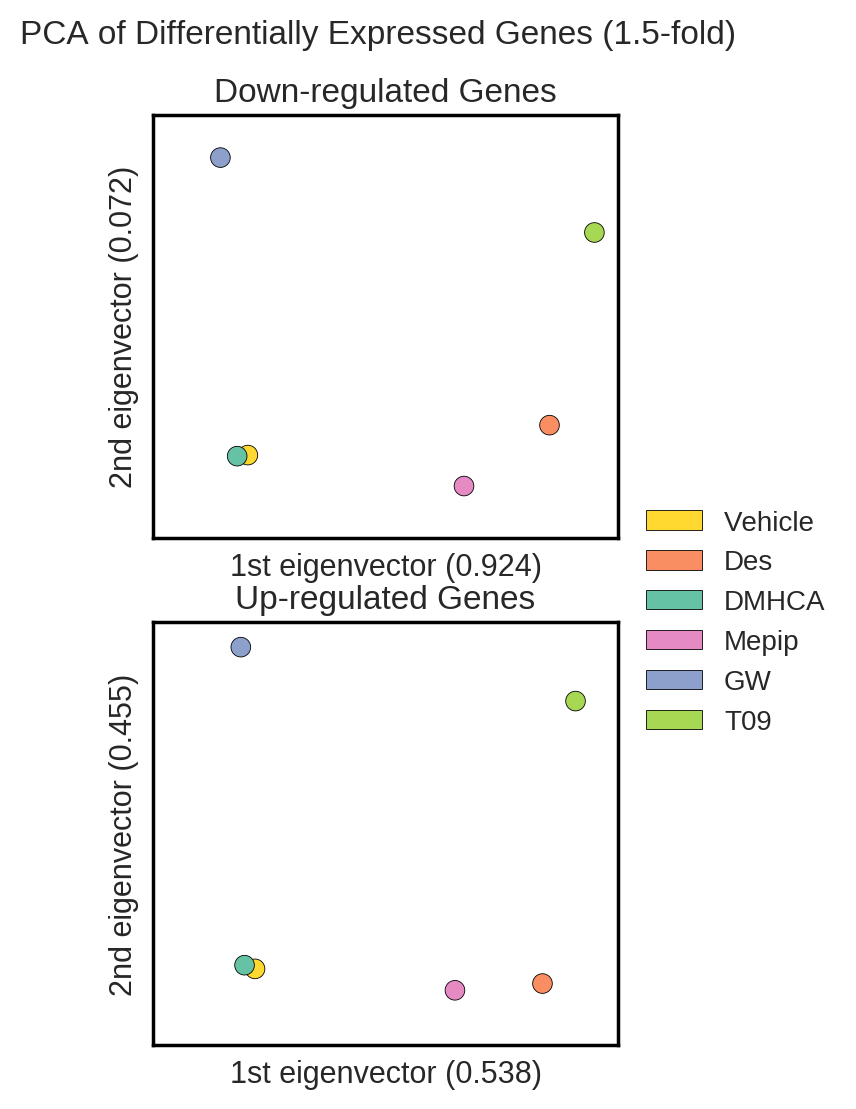

In [70]:
### for up-regulated genes
from matplotlib import patches as mpatches

colorDict = dict(zip(sorted(set(filtered_summary_frame['simpleTreatment'].values)), 
                 sns.color_palette("Set2") + sns.color_palette("colorblind")))

fdr_threshold = 0.05
fold_threshold = np.log2(1.5)
fdr_cols = [x for x in diffExpression_frame.columns if 'FDR' in x and 'vs. Vehicle' in x]
fold_cols = [x for x in diffExpression_frame.columns if 'logFC' in x and 'vs. Vehicle' in x]

down_diff_genes = diffExpression_frame[(diffExpression_frame[fdr_cols].min(axis=1) < fdr_threshold) &
                                  (diffExpression_frame[fold_cols].max(axis=1) >= fold_threshold)
                                 ]['gene'].values
down_diff_genes = [x.upper() for x in down_diff_genes]

up_diff_genes = diffExpression_frame[(diffExpression_frame[fdr_cols].min(axis=1) < fdr_threshold) &
                                  (diffExpression_frame[fold_cols].min(axis=1) <= -1*fold_threshold)
                                 ]['gene'].values
up_diff_genes = [x.upper() for x in up_diff_genes]

print('num down', len(down_diff_genes), 'num up', len(up_diff_genes))
f, axs = plt.subplots(2,1, figsize=(3,6))
plt.suptitle('PCA of Differentially Expressed Genes (1.5-fold)')

### down_regulated genes
features = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(down_diff_genes)]
colors = [colorDict[x] for x in features.columns.values]

down_model = sklearn.decomposition.PCA(n_components=2)
reduced_features = down_model.fit_transform(features.T)
explained_variance_ratios = down_model.explained_variance_ratio_

plt.subplot(2,1,1)  
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, s=50)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])
plt.title('Down-regulated Genes')

### up-regulatd genes
features = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(up_diff_genes)]
colors = [colorDict[x] for x in features.columns.values]

up_model = sklearn.decomposition.PCA(n_components=2)
reduced_features = up_model.fit_transform(features.T)
explained_variance_ratios = up_model.explained_variance_ratio_

plt.subplot(2,1,2)  
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, s=50)
plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])
plt.title('Up-regulated Genes')

# legend
classes = ['Vehicle', 'Des', 'DMHCA', 'Mepip','GW', 'T09']

classes = [x for x in classes if not '30' in x]
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc='right', bbox_to_anchor=(1.5, 1.0))

plt.savefig('pca_1.5fold.pdf',bbox_inches='tight')
plt.show()

In [60]:
for g in up_diff_genes:
    print(g)

SNORD47
MIR421
LRRC9
CRTAM
SLC25A47
FRY
CD52
ELAVL3
ZFP69
SCD2
CTSS
KBTBD12
AVPR1A
CXCL1
CHDH
HLF
HSD17B1
JAG2
GM1322
SLFN10-PS
PFKFB3
GM16938
DCN
TRANK1
MATN4
D7ERTD143E
HS3ST4
4921506M07RIK
CLIC3
OSR1
KL
RIMBP3
GPR12
ABCA1
RAD51AP1
DZANK1
THBS1
ST8SIA4
HDGFRP3
D030018L15RIK
TMEM74B
GM11437
UGT2B35
D4ERTD617E
SLCO2B1
SERPINA3F
C920006O11RIK
CMKLR1
FOXRED2
CEP85L
THEMIS2
ZAP70
PPP1R3G
CCDC166
D630045M09RIK
GM19619
TBXAS1
EFCAB5
SNORD95
GPR135
GBP8
ABCG1
0610043K17RIK
TOMM20L
NPTX1
D630033O11RIK
WEE2
FCNA
SELE
SLC10A1
TRIM16
CSF2RB2
FGF2
GRIK5
4931423N10RIK
ITGAL
CCBL1
HIP1
GMPR
ITGB1BP2
SAPCD1
ZBTBD6
A230028O05RIK
GJC1
MYCBPAP
TMPRSS11B
PLA2G4A
ASB14
AV051173
BC037704
BCAT1
ELOVL2
RTKN2
PDLIM2
ANKRD29
BTBD16
SNORA16A
ARHGEF28
D630032N06RIK
CACNA1A
PLAT
CDCA3
RAP1GAP2
KCNV2
GGT7
5133400J02RIK
IL7R
PTPRU
GM14858
PSRC1
OLFR99
CYP2J9
MECOM
2010010A06RIK
SCN3A
MIR6904
2010016I18RIK
LRRC15
CENPE
BNIPL
ADAM4
1700017D01RIK
ANKMY1
USP43
MIR568
IFNAB
HAMP2
6030498E09RIK
SRXN1
KRT7
CHIL6
MIR3473G

In [61]:
for g in down_diff_genes:
    print(g)

MIR421
LRRC9
GM14023
SLC25A47
ACSS2OS
CD52
ELAVL3
ZFP69
SCD2
TSPAN6
CTSS
KBTBD12
AVPR1A
CXCL1
CHDH
HLF
HSD17B1
JAG2
TNFRSF4
SLFN10-PS
RPL36
PFKFB3
DCN
TRANK1
MATN4
D7ERTD143E
HS3ST4
OSR1
KL
RIMBP3
SNHG1
GPR12
ABCA1
TBX2
DZANK1
NEB
PITPNC1
ST8SIA4
4930581F22RIK
HDGFRP3
D030018L15RIK
TMEM74B
GM11437
UGT2B35
LST1
SLCO5A1
SLCO2B1
SERPINA3F
AKT3
CMKLR1
FOXRED2
TCEANC
CEP85L
THEMIS2
ZAP70
PPP1R3G
CCDC166
GM19619
TBXAS1
EFCAB5
SNORD95
GBP8
ABCG1
0610043K17RIK
TOMM20L
NPTX1
D630033O11RIK
WEE2
F8
FCNA
SELE
SLC10A1
TRIM16
CSF2RB2
FGF2
GRIK5
4931423N10RIK
MIR6986
2310014L17RIK
ITGAL
CCBL1
GMPR
ITGB1BP2
SAPCD1
ZBTBD6
A230028O05RIK
GJC1
MYCBPAP
TMPRSS11B
FAM228B
PLA2G4A
ASB14
GM14326
AV051173
BC037704
BCAT1
RTKN2
PDLIM2
ANKRD29
BTBD16
SNORA16A
ARHGEF28
LRIT3
CACNA1A
PLAT
CDCA3
KCNV2
GGT7
5133400J02RIK
IL7R
PTPRU
GM14858
PSRC1
OLFR99
MECOM
2010010A06RIK
SCN3A
MIR6904
2010016I18RIK
LRRC15
KLHL7
CENPE
GAL3ST4
AU041133
BNIPL
ADAM4
1700017D01RIK
ANKMY1
USP43
MIR568
BC025920
IFNAB
HAMP2
LEAP2
6030498E09R